# Spiculation Classifier

## Import Libraries and paths to files.

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import pickle
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

# from google.colab import output

In [ ]:
a = tf.random.uniform((100000,100000), maxval=10000, dtype=tf.int32)
a

In [ ]:
b = tf.reduce_sum(a, 1, keepdims=True)
b

In [ ]:
tf.reduce_sum(tf.math.divide(a, b), 1, keepdims=True)

In [ ]:
1/41

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
df_path = '/content/drive/MyDrive/Colab Notebooks/Research/parsedXMLnew.xlsx'
ds_path = '/content/nodules'
ds_file_1 = '/content/drive/MyDrive/Colab Notebooks/Research/dataset_before_bin.pickle'
ds_file_2 = '/content/drive/MyDrive/Colab Notebooks/Research/dataset_bin.pickle'
ds_file_grad = '/content/drive/MyDrive/Colab Notebooks/Research/dataset_grad.pickle'
save_path = '/content/drive/MyDrive/Colab Notebooks/Research/'

### Functions

#### Global

In [ ]:
def plot_heatmap(y_true, y_pred, class_names, ax, title):
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(
      cm, 
      annot=True, 
      square=True, 
      xticklabels=class_names, 
      yticklabels=class_names,
      fmt='d', 
      cmap=plt.cm.Blues,
      cbar=False,
      ax=ax
  )
  ax.set_title(title, fontsize=16)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  ax.set_ylabel('True Label', fontsize=12)
  ax.set_xlabel('Predicted Label', fontsize=12)

def disp_and_save_cam(img, gradcam, name, conv_layer_name):
    save_path = '/content/drive/MyDrive/Colab Notebooks/Research/visuals/'

    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(1,3,1, title='Image with CAM')
    plt.imshow(img)
    plt.imshow(gradcam, alpha=0.5)
    plt.axis('off')

    fig.add_subplot(1,3,2, title='Image')
    plt.imshow(img)
    plt.imshow(img, alpha=0.5)
    plt.axis('off')

    fig.add_subplot(1,3,3, title='CAM')
    plt.imshow(gradcam)
    plt.axis('off')
    # plt.savefig(f'{save_path}{conv_layer_name}/{name}.png')
    plt.show()
def gradcam(img, model, last_conv_layer_name, label, show=False, name=''):
  last_conv_layer = model.get_layer(last_conv_layer_name)
  last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

  classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input 
  begin = False                
  for count, layer in enumerate(model.layers):
    if last_conv_layer_name == layer.name:
      begin = True
    if begin:
      x = layer(x)
      
  classifier_model = tf.keras.Model(classifier_input, x)

  with tf.GradientTape() as tape:
    inputs = img[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    pred = classifier_model(last_conv_layer_output)
    pred_class = 1 if tf.greater(pred, 0.5).numpy()[0,0] == True else 0

  grads = tape.gradient(pred, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))


  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
  
  # Average over all the filters to get a single 2D array
  gradcam = np.mean(last_conv_layer_output, axis=-1)
  # Clip the values (equivalent to applying ReLU)
  # and then normalise the values
  gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
  gradcam = cv2.resize(gradcam, img.shape[:2])

  if show:
    disp_and_save_cam(img, gradcam, name, last_conv_layer_name)

#### Model 1

In [ ]:
def create_model_1(input_shape, bin_act_func, optimizer, loss_func=''):
  # VGG16 convolutional layers
  conv_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
  # Freeze all conv_layers
  for layer in conv_base.layers:
    layer.trainable = False

  # Custom FC layers
  top_model = tf.keras.Sequential(
      [
        tf.keras.layers.GlobalAveragePooling2D(name='GAP_layer'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax', name='output_layer')
      ]
  )
  # Concat both models into one.
  model = tf.keras.Sequential()
  for layer in conv_base.layers:
    model.add(layer)
  model.add(top_model)
  model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])
  return model

def fine_tune_model_1(num_layers, input_shape, bin_act_func, optimizer, loss_func, fname):
  # VGG16 convolutional layers
  conv_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
  
  num_frozen = len(conv_base.layers)-num_layers-1
  # Freeze required conv_layers
  for layer in conv_base.layers[:num_frozen]:
    layer.trainable = False

  # Custom FC layers
  top_model = tf.keras.Sequential(
      [
        tf.keras.layers.GlobalAveragePooling2D(name='GAP_layer'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax', name='output_layer')
      ]
  )
  
  # Concat both models into one.
  model = tf.keras.Sequential()
  for layer in conv_base.layers:
    model.add(layer)
  model.add(top_model)
  model.load_weights(fname)
  model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])
  return model

#### Model 2

In [ ]:
def create_model_2(input_shape, dp_rates, bin_act_func, optimizer, loss_func=''):
  # VGG16 convolutional layers
  conv_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
  # Freeze all conv_layers
  for layer in conv_base.layers:
    layer.trainable = False

  # Custom FC layers
  top_model = tf.keras.Sequential(
      [
        tf.keras.layers.GlobalAveragePooling2D(name='GAP_layer'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(dp_rates[0]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dp_rates[1]),       
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dp_rates[2]),
        tf.keras.layers.Dense(3, activation='softmax', name='output_layer')
      ]
  )
  # Concat both models into one.
  model = tf.keras.Sequential()
  for layer in conv_base.layers:
    model.add(layer)
  model.add(top_model)
  model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])
  return model

def fine_tune_model_2(num_layers, input_shape, dp_rates, bin_act_func, optimizer, loss_func, fname):
  # VGG16 convolutional layers
  conv_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
  
  num_frozen = len(conv_base.layers)-num_layers-1
  # Freeze required conv_layers
  for layer in conv_base.layers[:num_frozen]:
    layer.trainable = False

  # Custom FC layers
  top_model = tf.keras.Sequential(
      [        
        tf.keras.layers.GlobalAveragePooling2D(name='GAP_layer'),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(dp_rates[0]),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(dp_rates[1]),       
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dp_rates[2]),
        tf.keras.layers.Dense(3, activation='softmax', name='output_layer')
      ]
  )
  
  # Concat both models into one.
  model = tf.keras.Sequential()
  for layer in conv_base.layers:
    model.add(layer)
  model.add(top_model)
  model.load_weights(fname)
  model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])
  return model

# Week 1

## Preprocessing



### Extract Labels and Binning Them

We only need the InstanceID (nodule id) and the Spiculation rating (label)

In [ ]:
df = pd.read_excel(df_path)
df = df[['InstanceID', 'spiculation']]
df.head()

Load the images and match their corresponding labels.

In [ ]:
shapes = []
ds = []
if os.path.isfile(ds_file_1):
  with open(ds_file_1, 'rb') as f:
    ds = pickle.load(f)
  for d in ds:
    shapes.append(d[0].shape)
  shapes = np.array(shapes)
else:
  !tar xzf '/content/drive/MyDrive/Colab Notebooks/Research/LIDC/nodules.tar.gz'

  file_names = glob(os.path.join(ds_path,'*.png'))
  id_set = set(df['InstanceID'])
  for f in file_names:
    id = int(f.split('/')[-1].split('.')[0])
    # print('InstanceID:', id, end='\n\n')
    if id in id_set:
      label =  df[df['InstanceID']==id]['spiculation'].iloc[0]
      img = cv2.imread(f, 0)
      shapes.append(img.shape)
      ds.append([img, label, id])
  shapes = np.array(shapes)

  with open(os.path.join(save_path,'dataset_before_bin.pickle'), 'wb') as f:
    pickle.dump(ds, f)

Load dataset from pickle file

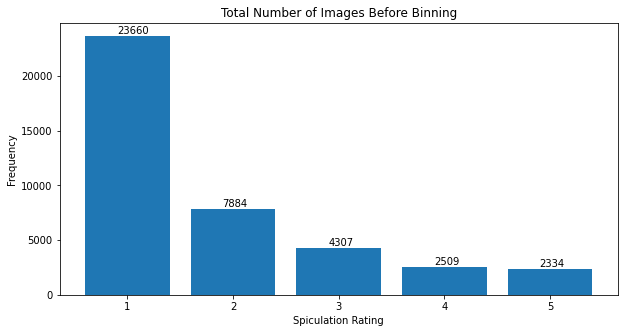

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Total Number of Images Before Binning')
labels, counts = np.unique([d[1] for d in ds], return_counts='True')
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Frequency')
plt.xlabel('Spiculation Rating')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + 200, yval)
plt.savefig(os.path.join(save_path,'bar_before_bin'))
plt.show()

Spiculation rating is, 1 least spiculation, to, 5 most spiculation. As we can see 1 has the most frequency compared to 5. Since this is just a ordinal variable, I have decided to bin values (1,2), 3, (4,5).

In [ ]:
df['spiculation'] = df['spiculation'].replace([2,4], [1,5])
df['spiculation'] = df['spiculation'].replace([1,3,5], [0,1,2])
df.head()

InstanceID  spiculation
0           1            2
1           2            2
2           3            2
3           4            2
4           5            2

In [ ]:
# if os.path.isfile(ds_file_2):
#   # with open(ds_file_2, 'rb') as f:
#   #   ds = pickle.load(f)
#   pass
# else:
for d in ds:
  d[1] =  df[df['InstanceID']==d[2]]['spiculation'].iloc[0]
    # print(d[1])

  # with open(os.path.join(save_path,'dataset_bin.pickle'), 'wb') as f:
  #   pickle.dump(ds, f)

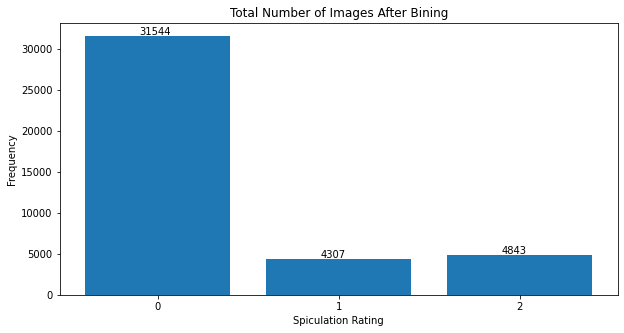

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Total Number of Images After Bining')
labels, counts = np.unique([d[1] for d in ds], return_counts='True')
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Frequency')
plt.xlabel('Spiculation Rating')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + 200, yval)
plt.savefig(os.path.join(save_path,'bar_bin'))
plt.show()

### Scaling Images


Since each nodule image is a different size. I wanted to see just how distribution of the number of rows and columsn for each image and other metrics as well.

<function matplotlib.pyplot.show>

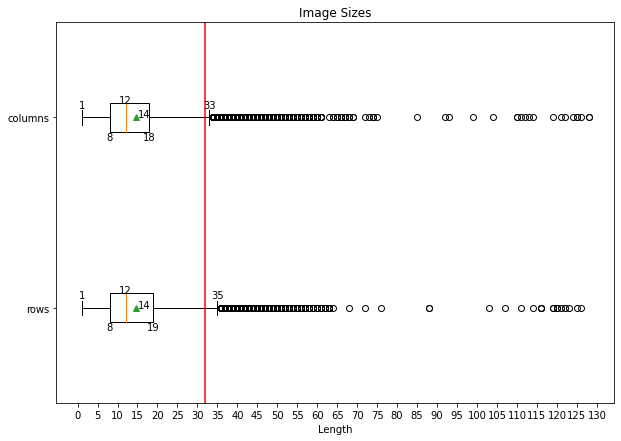

In [ ]:
fig = plt.figure(figsize=(10,7))
bp = plt.boxplot(shapes, showmeans=True, vert=False)

for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.text(x, y+.002, '%d' % x,
         horizontalalignment='center') # draw above, centered

for line in bp['whiskers']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.text(x, y+.05, '%d' % x,
         horizontalalignment='center') # draw above, centered

for line in bp['means']:
    # get position data for median line
    x, y = line.get_xydata()[0] # top of median line
    # overlay median value
    plt.text(x+2, y+.00, '%d' % x,
         horizontalalignment='center') # draw above, centered

for line in bp['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    plt.text(x,y-.002, '%d' % x,
         horizontalalignment='center', # centered
         verticalalignment='top')      # below
    x, y = line.get_xydata()[3] # bottom of right line
    plt.text(x,y-.002, '%d' % x,
         horizontalalignment='center', # centered
             verticalalignment='top')      # below

line = plt.axvline(32, 0, color='r')


plt.yticks([1,2], ['rows','columns'])
plt.xticks(np.arange(0,np.max(shapes)+5,step=5))
plt.xlabel('Length')
plt.title('Image Sizes')
plt.savefig(os.path.join(save_path,'image_sizes_before'))
plt.show

As we can see, there are a good amount of outliers. But most of the image sizes are between (8,8) to (18,19). Since VGG16 can support images down to a size of (48,48) (red line), so I will resize the necesary images to (48,48). BiCubic Interpolation for up-scaling and down-scaling using area relation.

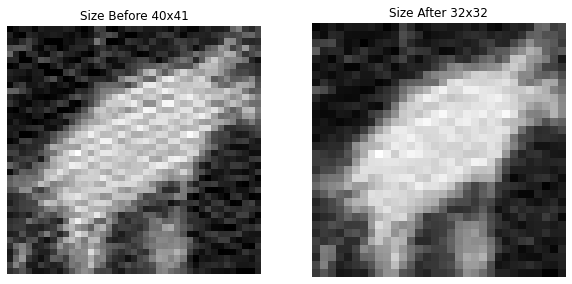

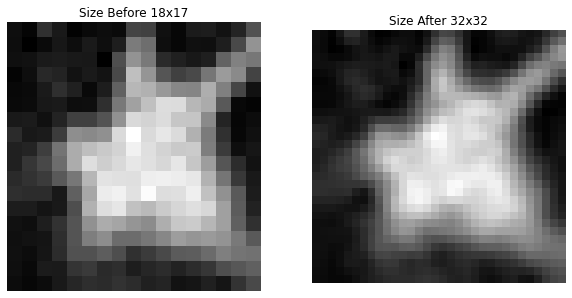

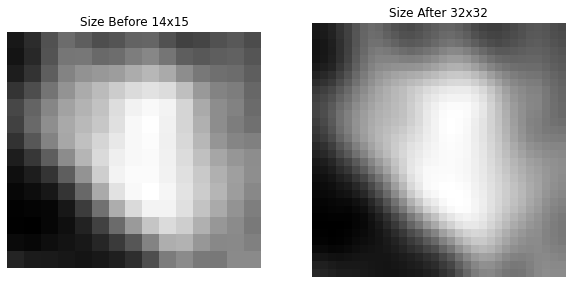

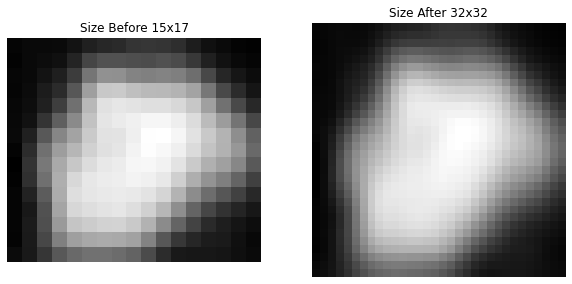

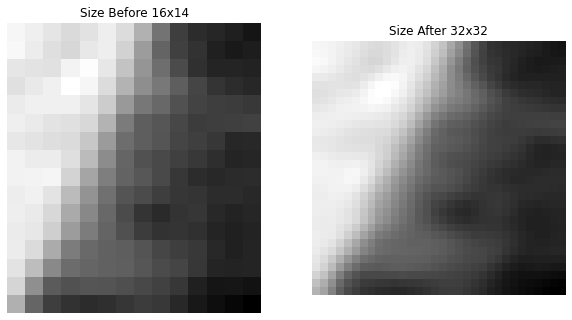

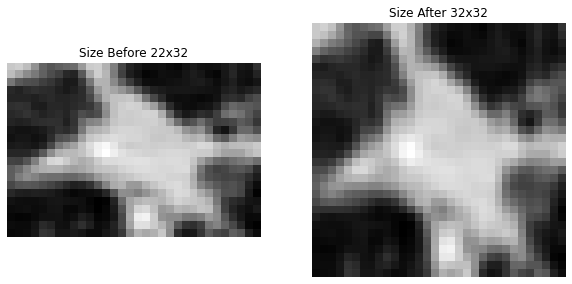

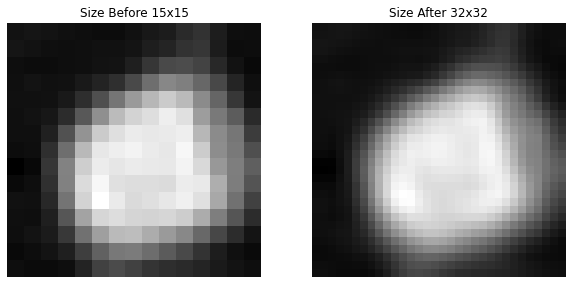

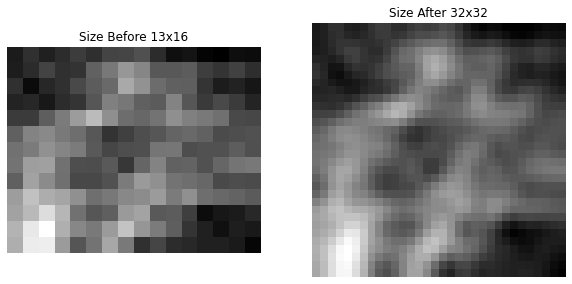

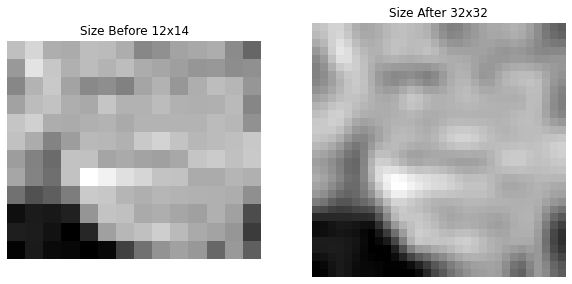

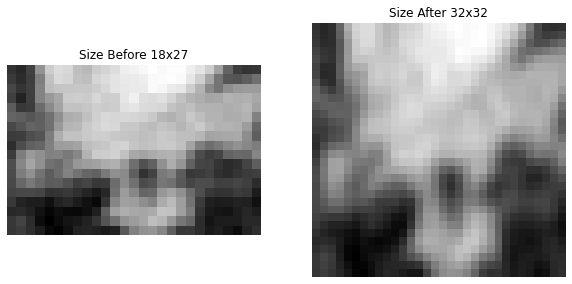

In [ ]:
temp = []
i = 0
for d in ds:
  if d[0].shape >= (12,12):
    if i < 10:
      fig = plt.figure(figsize=(10,10))
      fig.add_subplot(1,2,1, title='Size Before {}x{}'.format(*d[0].shape,))
      plt.imshow(d[0], cmap='gray')
      plt.axis('off')
    if d[0].shape < (32,32):
      # Up-Scaling
      d[0] = cv2.resize(d[0], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
    elif d[0].shape > (32,32):
      # Down-Scaling
      d[0] = cv2.resize(d[0], dsize=(32,32), interpolation=cv2.INTER_AREA)
    temp.append(d)
  
    if i < 10:
      fig.add_subplot(1,2,2, title='Size After {}x{}'.format(*d[0].shape,))
      plt.imshow(d[0], cmap='gray')
      plt.axis('off')
      plt.savefig(os.path.join(save_path, 'nodules_scale_%d'%i))
      plt.show()
      i+=1
del(ds)
ds = temp

### Grayscale -> RGB
Unfortunately VGG16 only takes RGB images. Since our images are grayscale, I'm just going to clone the image matrix to each color channel.

In [ ]:
for d in ds:
  d[0] = np.dstack([d[0]]*3)

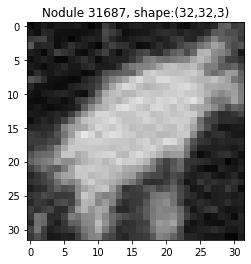

In [ ]:
  plt.title('Nodule %d, shape:(%d,%d,%d)'%(ds[0][2], *ds[0][0].shape,))
  plt.imshow(ds[0][0])
  plt.show()

### Split Training and Test Sets
Now that we have the dataset ready. Its time to split it into training and test sets, as well as randomizing and converting to tensors.

In [ ]:
X = []
y = []
for d in ds:
  X.append(d[0])
  y.append(d[1])
X = np.array(X)
y = np.array(y)
y

array([0, 2, 0, ..., 2, 0, 2])

Lastly, we will also use One-Hot Encoding on the labels.

In [ ]:
# y = LabelBinarizer().fit_transform(y)
y = tf.keras.utils.to_categorical(y, num_classes=3)
y

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)#, random_state=1)

## Transfer Learning with VGG16

### Compile the Model
I will be adapting a similar model that was used in [1]. The model before fine tuning will include:


*   VGG16 with Convolutional Layers 
*   Golbal Average Pooling Layer
*   Three Fully Connected Layers (FC)
  *   FC(512)->FC(256)->FC(128)
*   Softmax Layer (3 classes)
*   Adam Optimizer with learning rate ($\eta$ = 0.001) 
*   Batch Size of 1024
*   Input size of 64x64x3
*   Validation split of .1


A few parameters we need for our model.

In [ ]:
n_epochs = 100
n_classes = 3
input_shape = (32,32,3)
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_func = 'categorical_crossentropy'

batch_size = 1024

In [ ]:
with strategy.scope():
  vgg16_1 = create_model_1(input_shape, n_classes, optim, loss_func)

### Training the Model
Now that our VGG16 with our custom fully connect top layer is compiled. It is time to fit the model with our nodule images. But first we need to define some callbacks to save the best weights at each epoch and to stop early if there is no change.

In [ ]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5', save_best_only=True, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

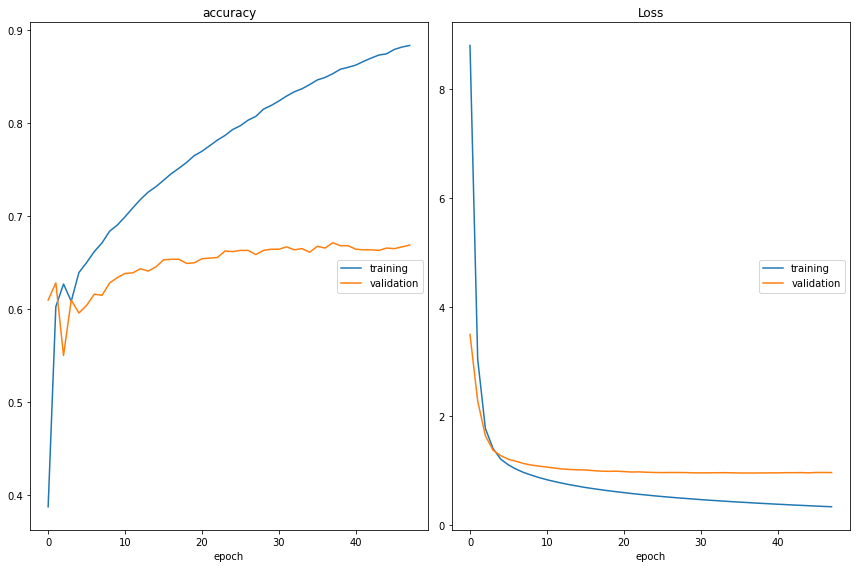

accuracy
	training         	 (min:    0.387, max:    0.883, cur:    0.883)
	validation       	 (min:    0.550, max:    0.671, cur:    0.669)
Loss
	training         	 (min:    0.342, max:    8.802, cur:    0.342)
	validation       	 (min:    0.961, max:    3.502, cur:    0.969)


In [ ]:
%time 
vgg_1_history = vgg16_1.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=n_epochs, verbose=2, callbacks=[tl_checkpoint_1, early_stop, plot_loss_1], validation_split=0.1)

### Predicting with the Test Set

In [ ]:
y_pred_probs_1 = vgg16_1.predict(X_test)
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)
y_true = np.argmax(y_test, axis=1)

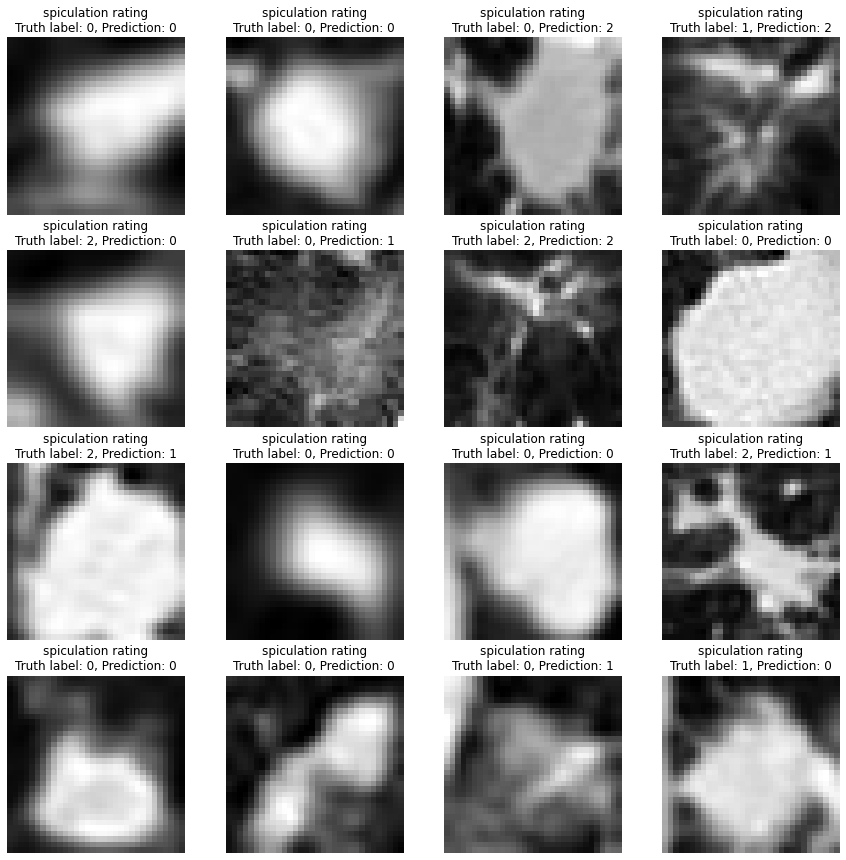

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_test[i].astype("uint8"))
  plt.title(f'spiculation rating\nTruth label: %d, Prediction: %d'%(y_true[i], y_pred_1[i]))
  plt.axis("off")

In [ ]:
vgg_1_history.epoch

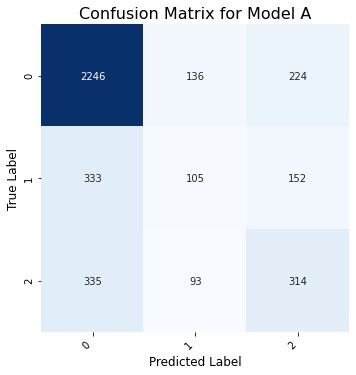

In [ ]:
class_names = ['0','1','2']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_heatmap(y_true, y_pred_1, class_names, ax, title="Confusion Matrix for Model A")    

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.savefig('conf_mat_A')
plt.show()

In [ ]:
loss, accuracy = vgg16_1.evaluate(X_test, y_test)
print('Test accuracy for Model 1:', accuracy)
print(classification_report(y_true, y_pred_1, digits=3))

124/124 [==============================] - 4s 19ms/step - loss: 0.9448 - accuracy: 0.6767
Test accuracy for Model 1: 0.6767394542694092
              precision    recall  f1-score   support

           0      0.771     0.862     0.814      2606
           1      0.314     0.178     0.227       590
           2      0.455     0.423     0.439       742

    accuracy                          0.677      3938
   macro avg      0.513     0.488     0.493      3938
weighted avg      0.643     0.677     0.655      3938



# Week 2 Random Sample

## Preprocessing Part II

In this section, we are going to balance the classes more to improve the accuracy of the model. The previous models had an average acuracy of roughly 78% and we hope that balancing the classes will result in a more acurate model.

Reload the dataset before scaling the image but after binning the classes.

In [ ]:
with open(ds_file_2, 'rb') as f:
  ds = pickle.load(f)

shapes = []
for d in ds:
  shapes.append(d[0].shape)
shapes = np.array(shapes)

### Scaling Images


First we want to see how the classes look if we include images bigger than 12x12. Previously we used 4x4 and bigger images. We will also scale the images to 32x32 (redline) instead of 64x64

<function matplotlib.pyplot.show>

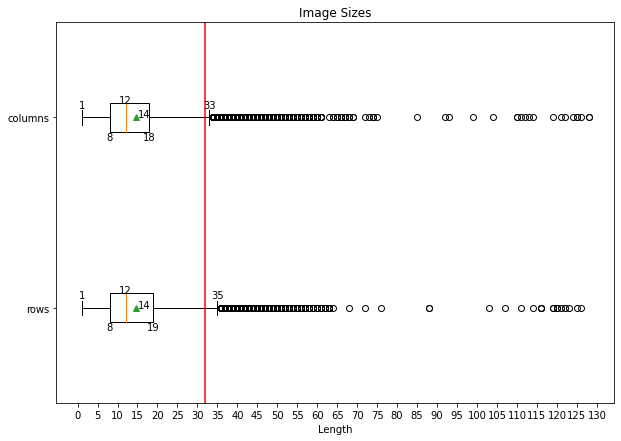

In [ ]:
fig = plt.figure(figsize=(10,7))
bp = plt.boxplot(shapes, showmeans=True, vert=False)

for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.text(x, y+.002, '%d' % x,
         horizontalalignment='center') # draw above, centered

for line in bp['whiskers']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.text(x, y+.05, '%d' % x,
         horizontalalignment='center') # draw above, centered

for line in bp['means']:
    # get position data for median line
    x, y = line.get_xydata()[0] # top of median line
    # overlay median value
    plt.text(x+2, y+.00, '%d' % x,
         horizontalalignment='center') # draw above, centered

for line in bp['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    plt.text(x,y-.002, '%d' % x,
         horizontalalignment='center', # centered
         verticalalignment='top')      # below
    x, y = line.get_xydata()[3] # bottom of right line
    plt.text(x,y-.002, '%d' % x,
         horizontalalignment='center', # centered
             verticalalignment='top')      # below

line = plt.axvline(32, 0, color='r')


plt.yticks([1,2], ['rows','columns'])
plt.xticks(np.arange(0,np.max(shapes)+5,step=5))
plt.xlabel('Length')
plt.title('Image Sizes')
plt.savefig(os.path.join(save_path,'image_sizes_before'))
plt.show

Scaling the Images

In [ ]:
temp = []
for i,d in enumerate(ds):
  # Use image with size >= (12,12)
  if d[0].shape >= (14,14):
    if d[0].shape < (128,128):
      # Up-Scaling
      d[0] = cv2.resize(d[0], dsize=(32,32), interpolation=cv2.INTER_CUBIC)
    elif d[0].shape > (32,32):
      # Down-Scaling
      d[0] = cv2.resize(d[0], dsize=(32,32), interpolation=cv2.INTER_AREA)
    temp.append(d)
del(ds)
ds = temp

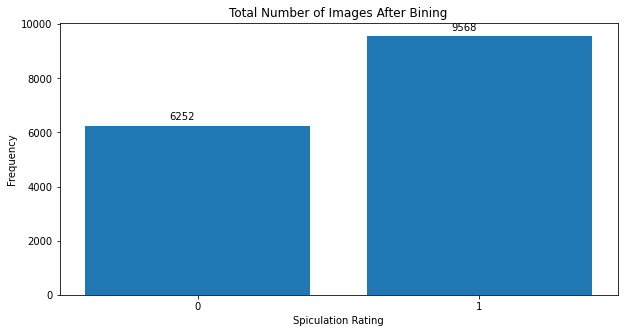

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Total Number of Images After Bining')
labels, counts = np.unique([d[1] for d in ds], return_counts='True')
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Frequency')
plt.xlabel('Spiculation Rating')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + 200, yval)
plt.savefig(os.path.join(save_path,'bar_bin'))
plt.show()

As we can see this significantly reduced our dataset. Class 0 is smaller but so is Class 1. We still need to balance the class size though.

### Randomly Sample from Classes

First we will split the elements into three list coresponding to thier class.

In [ ]:
class_0, class_1, class_2 = [],[],[]
for d in ds:
  if d[1] == 0:
    class_0.append(d)
  elif d[1] == 1:
    class_1.append(d)
  elif d[1] == 2:
    class_2.append(d)

In order to balance the classes we decided on randomly sampling from each class until we have an equal number of samples from each class. To try this method out. We will be sampling total of 2900 samples from each class.

In [ ]:
ds2 = []
bin_size = min(len(class_0), len(class_1), len(class_2))
# Current number of samples randomly sampled from each class.
num_0, num_1, num_2 = 0,0,0

# Set containing the indexs already chosen.
used_samples = set()

# Randomly sample from each class with out replacement until we have balanced classes.
# Begin with randomly selecting from class 0
while num_0 < bin_size:
  rand_sample = np.random.randint(low=0, high=len(class_0))
  if rand_sample not in used_samples:
    num_0 += 1
    ds2.append(class_0[rand_sample])
    used_samples.add(rand_sample)

# Reset and run for class 1
used_samples = set()
while num_1 < bin_size:
  rand_sample = np.random.randint(low=0, high=len(class_1))
  if rand_sample not in used_samples:
    num_1 += 1
    ds2.append(class_1[rand_sample])
    used_samples.add(rand_sample)

# Reset and run for class 2
used_samples = set()
while num_2 < bin_size:
  rand_sample = np.random.randint(low=0, high=len(class_2))
  if rand_sample not in used_samples:
    num_2 += 1
    ds2.append(class_2[rand_sample])
    used_samples.add(rand_sample)

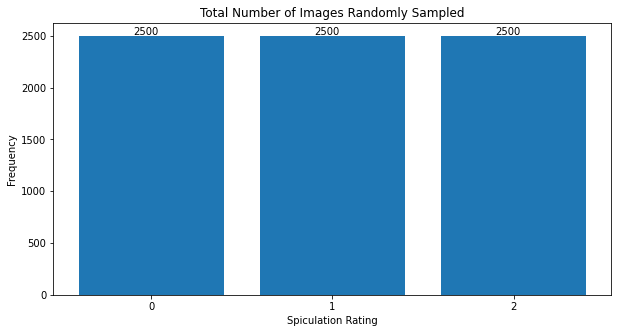

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Total Number of Images Randomly Sampled')
labels, counts = np.unique([d[1] for d in ds2], return_counts='True')
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Frequency')
plt.xlabel('Spiculation Rating')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + 10, yval)
plt.savefig(os.path.join(save_path,'bar_bin'))
plt.show()

Much better results. We have a balanced dataset but we have significantly reduced the number of images though. Now we will see if this tradeoff is worth it. But first a couple more of preprocessing before we begin trading our model.

### Grayscale -> RGB
Unfortunately VGG16 only takes RGB images. Since our images are grayscale, I'm just going to clone the image matrix to each color channel.

In [ ]:
for d in ds2:
  d[0] = np.dstack([d[0]]*3)

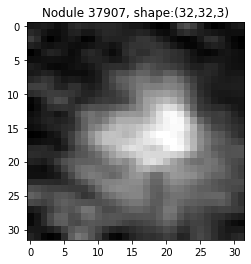

In [ ]:
  plt.title('Nodule %d, shape:(%d,%d,%d)'%(ds2[0][2], *ds2[0][0].shape,))
  plt.imshow(ds2[0][0])
  plt.show()

### Split Training and Test Sets
Now that we have the dataset ready. Its time to split it into training and test sets, as well as randomizing and converting to tensors.

In [ ]:
X = []
y = []
for d in ds2:
  X.append(d[0])
  y.append(d[1])
X = np.array(X)
y = np.array(y)
y

array([0, 0, 0, ..., 2, 2, 2])

Lastly, we will also use One-Hot Encoding on the labels.

In [ ]:
# y = LabelBinarizer().fit_transform(y)
y = tf.keras.utils.to_categorical(y, num_classes=3)
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)#, random_state=1)

In [ ]:
print('Training Set Size:',len(X_train), '\nTest Set Size:', len(X_test))

Training Set Size: 6000 
Test Set Size: 1500


## Transfer Learning with VGG16 Part II

---



### Compile the Model
I will be adapting a similar model that was used in [1]. The model before fine tuning will include:


*   VGG16 with Convolutional Layers 
*   Golbal Average Pooling Layer
*   Three Fully Connected Layers (FC)
  *   FC(512)->FC(256)->FC(128)
*   Softmax Layer (3 classes)
*   Adam Optimizer with learning rate ($\eta$ = 0.001) 
*   Batch Size of 64
*   Input size of 32x32x3
*   Validation split of .1


A few parameters we need for our model.

In [ ]:
n_epochs = 100
n_classes = 3
input_shape = (32,32,3)
learning_rate = 0.0001
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_func = 'categorical_crossentropy'

batch_size = 64

In [ ]:
with strategy.scope():
  vgg16_1 = create_model_1(input_shape, n_classes, optim, loss_func)

Model: "model_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_115 (InputLayer)       [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0 

### Training the Model
Now that our VGG16 with our custom fully connect top layer is compiled. It is time to fit the model with our nodule images. But first we need to define some callbacks to save the best weights at each epoch and to stop early if there is no change.

In [ ]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5', save_best_only=True, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

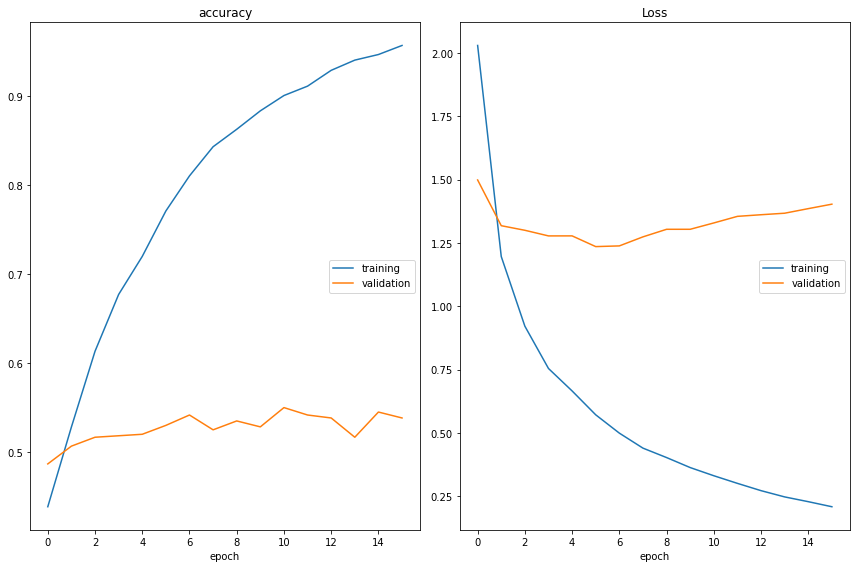

accuracy
	training         	 (min:    0.439, max:    0.957, cur:    0.957)
	validation       	 (min:    0.487, max:    0.550, cur:    0.538)
Loss
	training         	 (min:    0.208, max:    2.029, cur:    0.208)
	validation       	 (min:    1.235, max:    1.498, cur:    1.403)


In [ ]:
%time 
vgg_1_history = vgg16_1.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=n_epochs, verbose=2, callbacks=[tl_checkpoint_1, early_stop, plot_loss_1], validation_split=0.1)

### Predicting with the Test Set

In [ ]:
y_pred_probs_1 = vgg16_1.predict(X_test)
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)
y_true = np.argmax(y_test, axis=1)

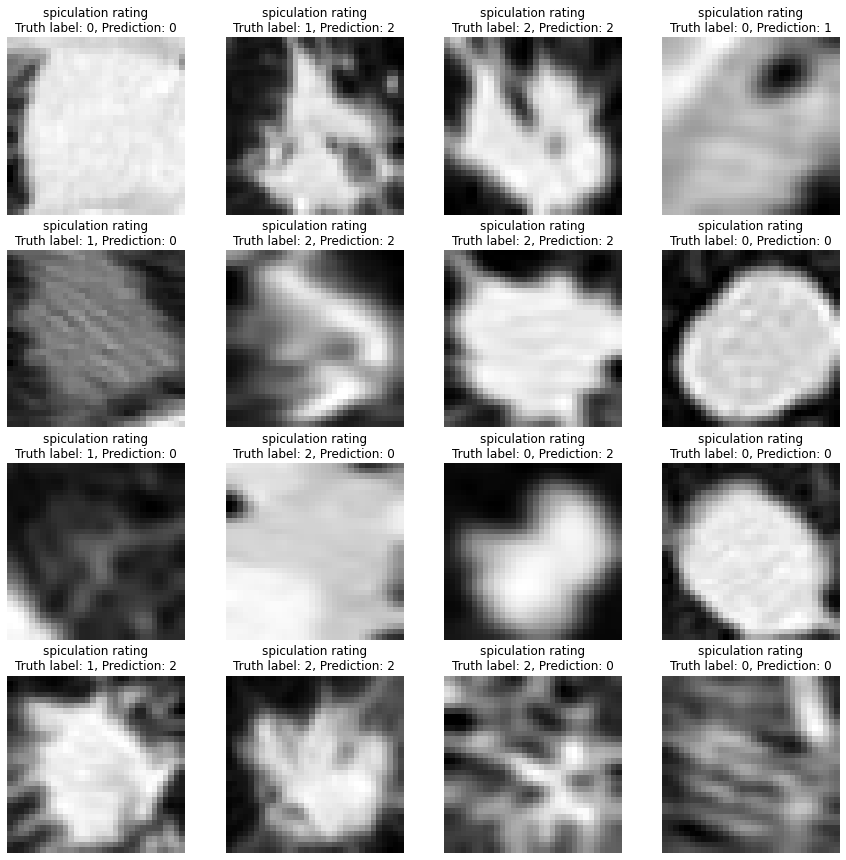

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_test[i].astype("uint8"))
  plt.title(f'spiculation rating\nTruth label: %d, Prediction: %d'%(y_true[i], y_pred_1[i]))
  plt.axis("off")

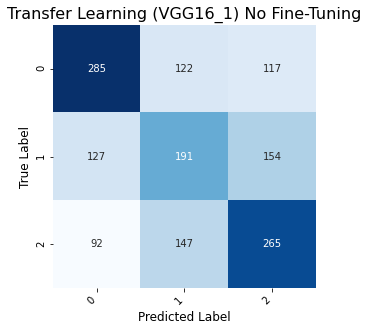

In [ ]:
class_names = ['0','1','2']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_heatmap(y_true, y_pred_1, class_names, ax, title="Transfer Learning (VGG16_1) No Fine-Tuning")    

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
loss, accuracy = vgg16_1.evaluate(X_test, y_test)
print('Test accuracy for Model 1:', accuracy)
print(classification_report(y_true, y_pred_1, digits=3))

47/47 [==============================] - 2s 12ms/step - loss: 1.2859 - accuracy: 0.4940
Test accuracy for Model 1: 0.49399998784065247
              precision    recall  f1-score   support

           0      0.565     0.544     0.554       524
           1      0.415     0.405     0.410       472
           2      0.494     0.526     0.510       504

    accuracy                          0.494      1500
   macro avg      0.492     0.491     0.491      1500
weighted avg      0.494     0.494     0.494      1500



### Fine-Tuning the Model


In [ ]:
optim_2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)
with strategy.scope():
  vgg16_2 = create_model_1(input_shape, n_classes, optim_2, loss_func, fine_tune=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


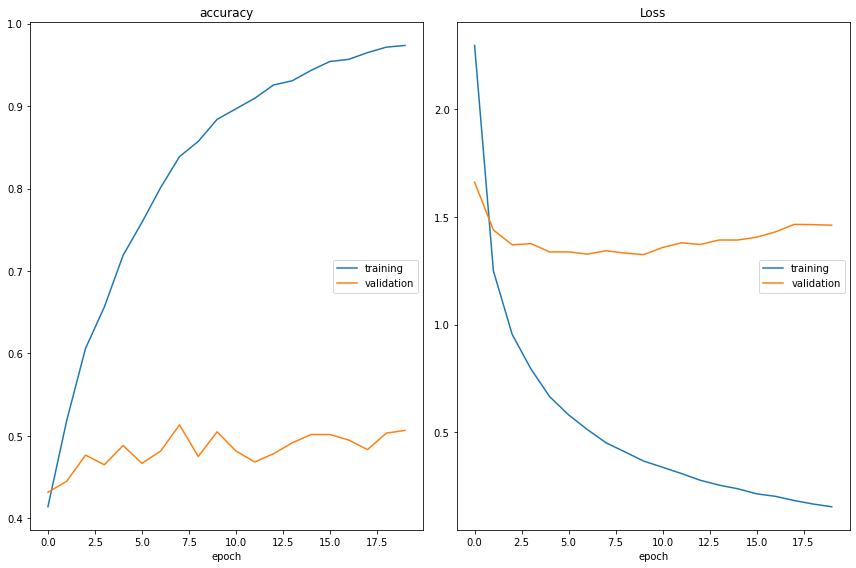

accuracy
	training         	 (min:    0.414, max:    0.974, cur:    0.974)
	validation       	 (min:    0.432, max:    0.513, cur:    0.507)
Loss
	training         	 (min:    0.155, max:    2.296, cur:    0.155)
	validation       	 (min:    1.325, max:    1.661, cur:    1.462)


In [ ]:
plot_loss_2 = PlotLossesCallback()

%time 
vgg_2_history = vgg16_2.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=n_epochs, verbose=2, callbacks=[tl_checkpoint_1, early_stop, plot_loss_2], validation_split=0.1)

In [ ]:
y_pred_probs_2 = vgg16_2.predict(X_test)
y_pred_2 = np.argmax(y_pred_probs_2, axis=1)

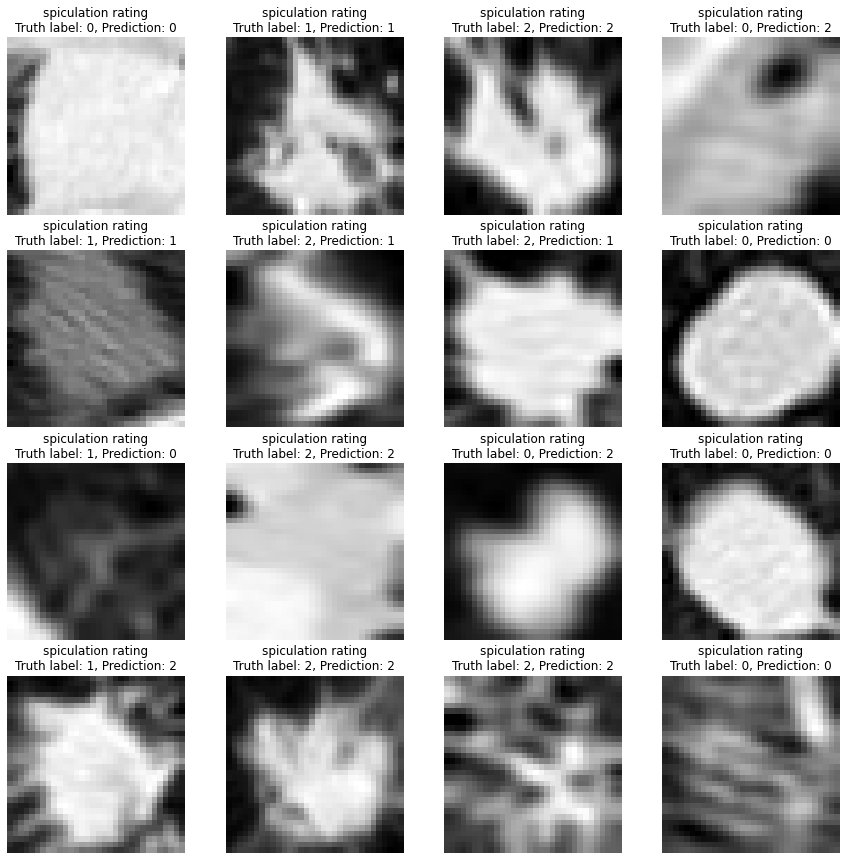

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_test[i].astype("uint8"))
  plt.title(f'spiculation rating\nTruth label: %d, Prediction: %d'%(y_true[i], y_pred_2[i]))
  plt.axis("off")

In [ ]:
loss, accuracy = vgg16_2.evaluate(X_test, y_test)
print('Test accuracy for Model 2:', accuracy)
print(classification_report(y_true, y_pred_2, digits=3))

47/47 [==============================] - 2s 12ms/step - loss: 1.2824 - accuracy: 0.5260
Test accuracy for Model 2: 0.5260000228881836
              precision    recall  f1-score   support

           0      0.596     0.603     0.600       524
           1      0.439     0.439     0.439       472
           2      0.533     0.528     0.530       504

    accuracy                          0.526      1500
   macro avg      0.523     0.523     0.523      1500
weighted avg      0.526     0.526     0.526      1500



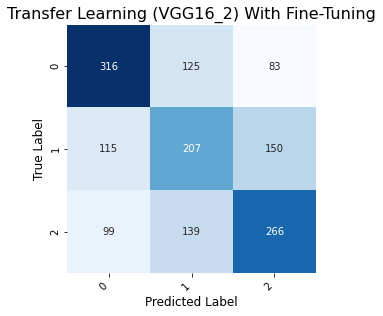

In [ ]:
class_names = ['0','1','2']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_heatmap(y_true, y_pred_2, class_names, ax, title="Transfer Learning (VGG16_2) With Fine-Tuning")    

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

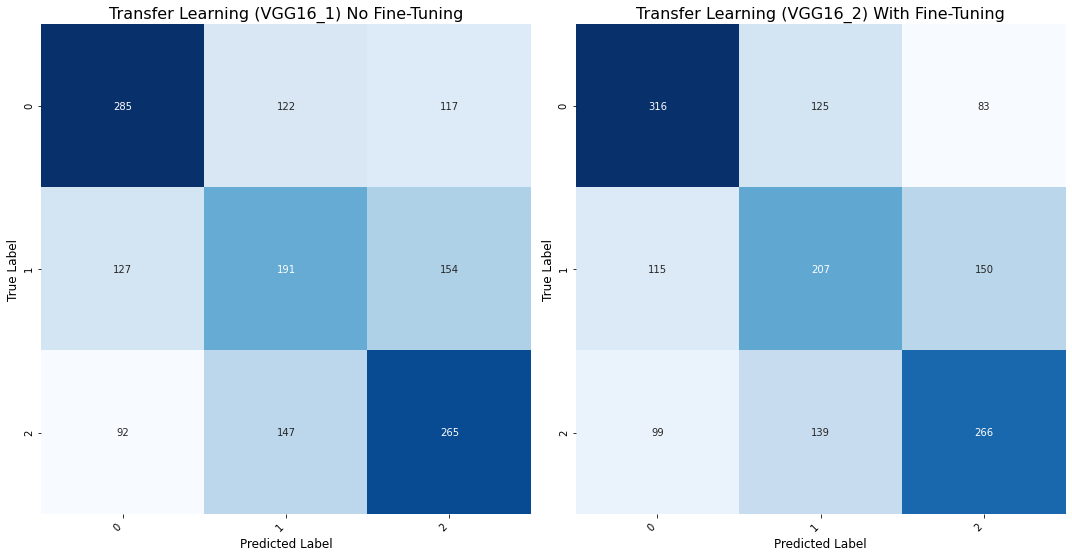

In [ ]:
class_names = ['0','1','2']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 20))

plot_heatmap(y_true, y_pred_1, class_names, ax1, title="Transfer Learning (VGG16_1) No Fine-Tuning")    
plot_heatmap(y_true, y_pred_2, class_names, ax2, title="Transfer Learning (VGG16_2) With Fine-Tuning")    

# fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

### Finding Best Params

In [ ]:
learning_rates = [0.001, 0.0001]
batch_size = [32, 64, 128, 256, 512, 1024]
history_1 = []

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
n_epochs = 100
n_classes = 3
input_shape = (32,32,3)
loss_func = 'categorical_crossentropy'

predictions_1 = []
iterations_left = len(learning_rates) * len(batch_size)

for lr in learning_rates:
  optim = tf.keras.optimizers.Adam(learning_rate=lr)
  with strategy.scope():
    model_1 = create_model_2(input_shape, n_classes, optim, loss_func)
  for bs in batch_size:
    print('\rIterations Left:', iterations_left, end='')
    iterations_left -= 1
    history_1.append(model_1.fit(x=X_train, y=y_train, batch_size=bs, epochs=n_epochs, verbose=0, callbacks=[early_stop], validation_split=0.2).history)
    predictions_1.append(np.argmax(model_1.predict(X_test), axis=1))

Iterations Left: 1

### Results

In [ ]:
with open(os.path.join(save_path,'history_1.pickle'), 'rb') as f:
  history_1 = pickle.load(f)
with open(os.path.join(save_path, 'predictions_1.pickle'), 'rb') as f:
  predictions_1 = pickle.load(f)

# with open(os.path.join(save_path,'history_2.pickle'), 'rb') as f:
#   history_2 = pickle.load(f)
# with open(os.path.join(save_path, 'predictions_2.pickle'), 'rb') as f:
#   predictions_2 = pickle.load(f)


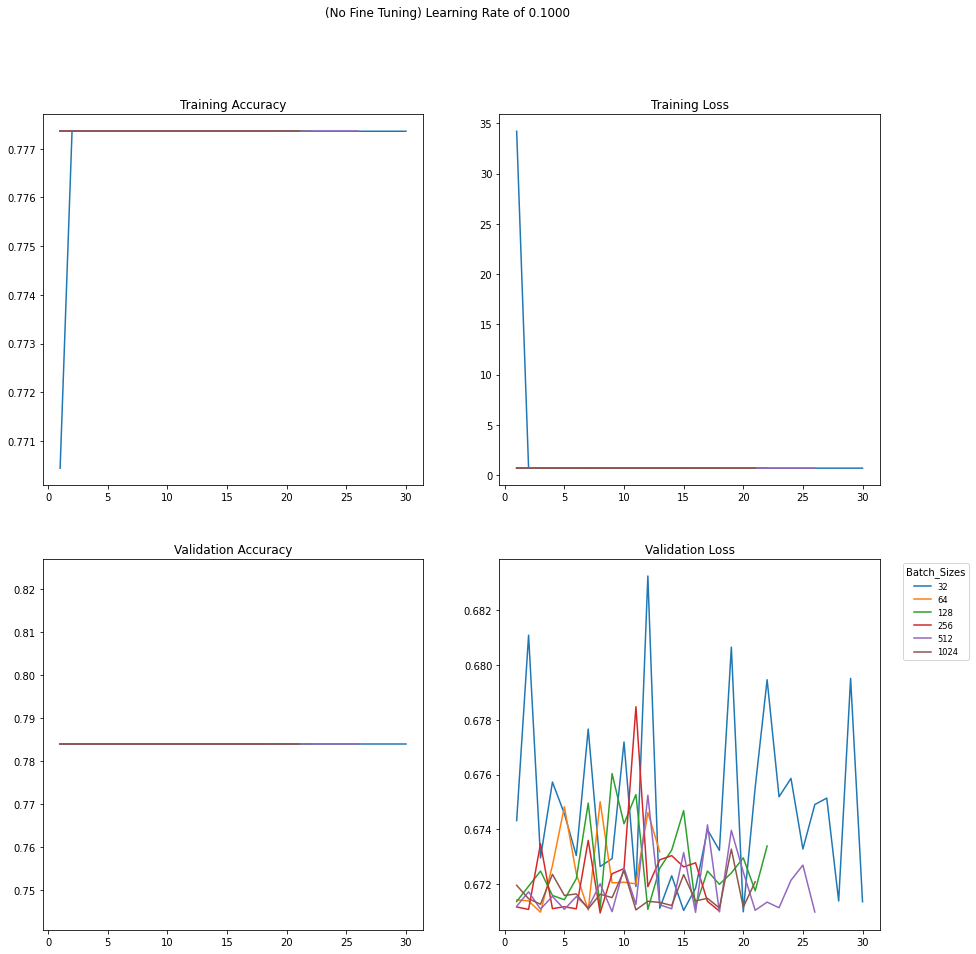

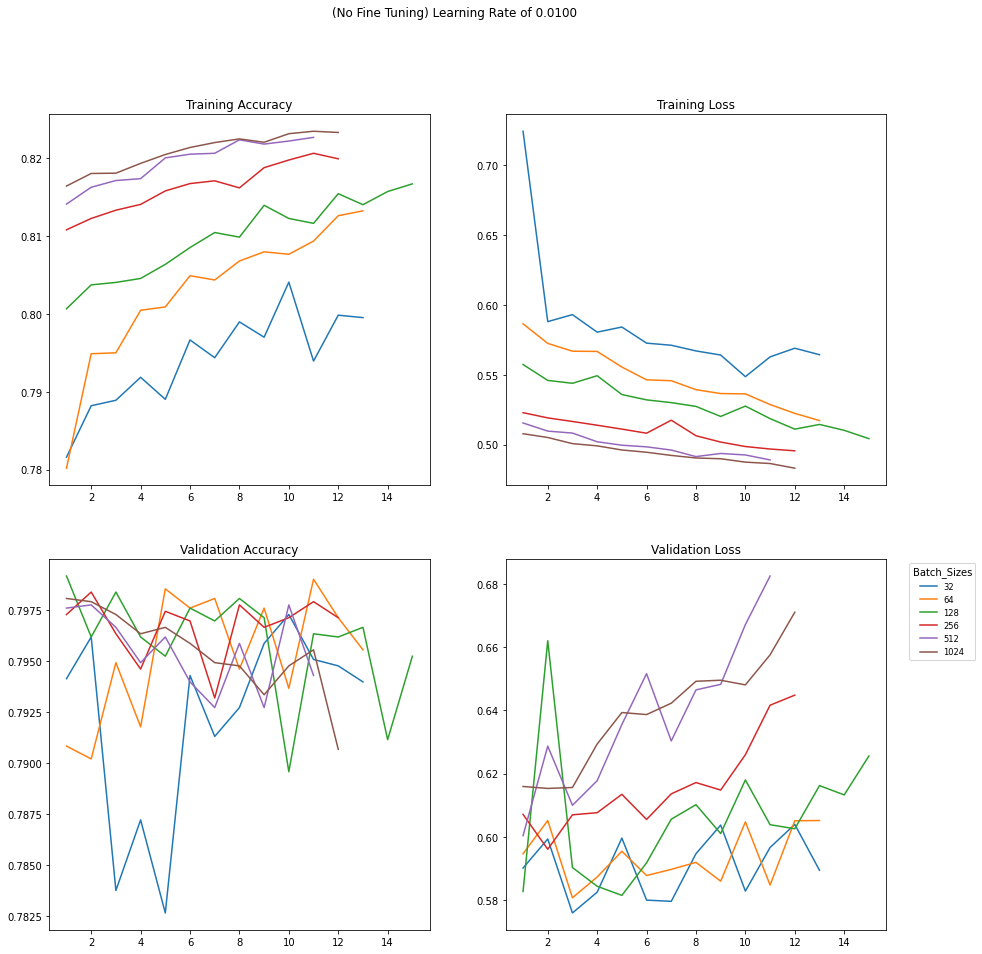

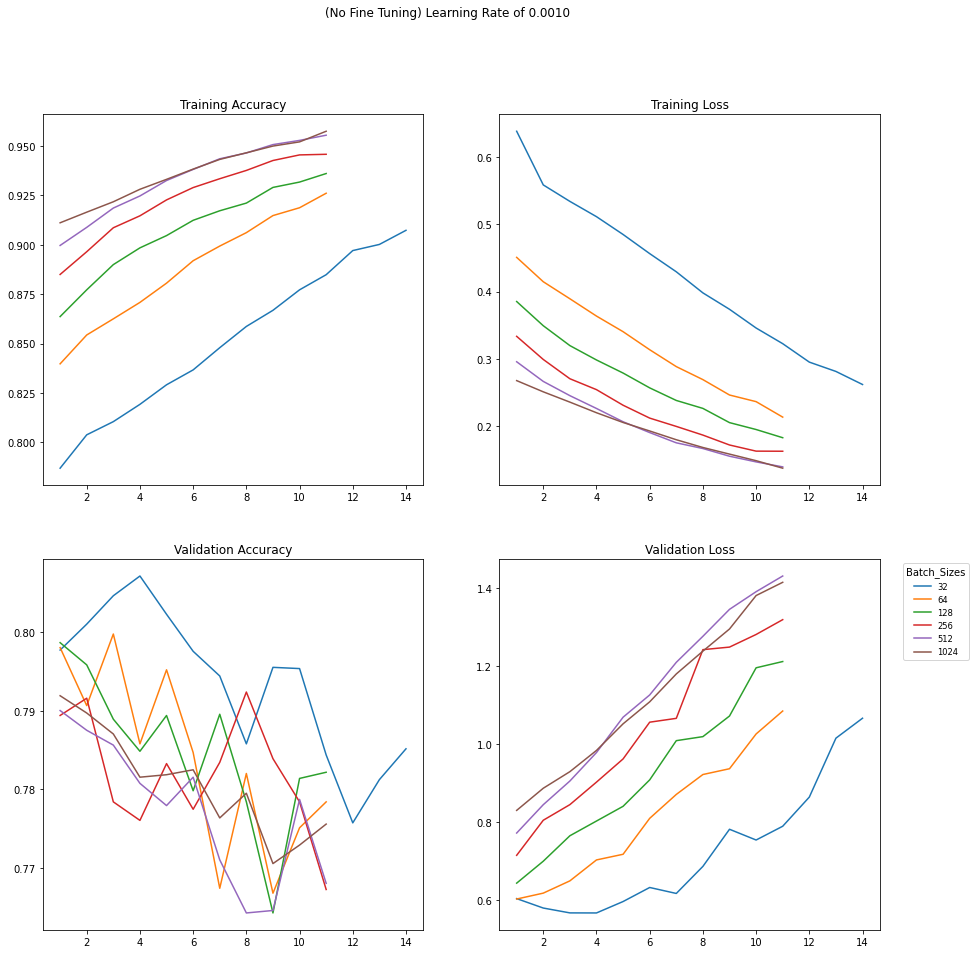

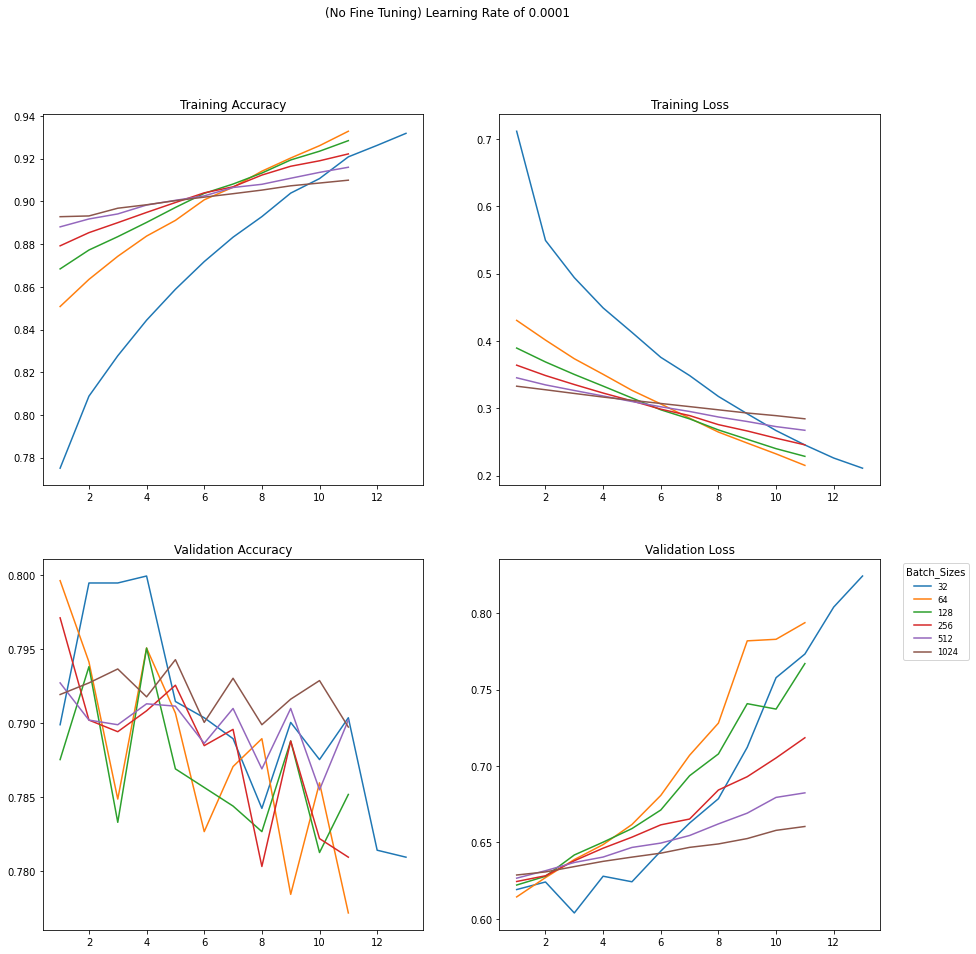

In [ ]:
from matplotlib.font_manager import FontProperties

learning_rates = [0.1, 0.01, 0.001, 0.0001]
batch_size = [32, 64, 128, 256, 512, 1024]
i,j = 0, 0
fontP = FontProperties()
fontP.set_size('small')
min_acc, max_acc = min((history_1[0])['accuracy']), max((history_1[0])['accuracy'])


for h in history_1:
  if j == 0:
    plt.figure(figsize=(15,15))
    plt.suptitle(f'(No Fine Tuning) Learning Rate of {learning_rates[i]:.4f}')
    ax1 = plt.subplot(2,2,1, title='Training Accuracy')
    ax2 = plt.subplot(2,2,2, title='Training Loss')
    ax3 = plt.subplot(2,2,3, title='Validation Accuracy')
    ax4 = plt.subplot(2,2,4, title='Validation Loss')

  tr_acc = h['accuracy']
  tr_loss = h['loss']
  ax1.plot(np.arange(1,len(tr_acc)+1), tr_acc,label=f'Batch_size: {batch_size[j]}')
  ax2.plot(np.arange(1,len(tr_loss)+1), tr_loss,label=f'Batch_size: {batch_size[j]}')

  val_acc = h['val_accuracy']
  val_loss = h['val_loss']
  ax3.plot(np.arange(1,len(val_acc)+1), val_acc,label=f'{batch_size[j]}')
  ax4.plot(np.arange(1,len(val_loss)+1), val_loss,label=f'{batch_size[j]}')

  j += 1
  if j == len(batch_size):
    j = 0

    # ax1.yticks(np.arange(0.5,1,.05))
    # ax2.yticks(np.arange(0.5,1,.05))
    # ax3.yticks(np.arange(0.5,1,.05))
    # ax4.yticks(np.arange(0.5,1,.05))    

    plt.legend(title='Batch_Sizes', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
    plt.savefig(os.path.join(save_path, 'Figures/', (f'(No Fine Tuning) Learning Rate of {learning_rates[i]:.4f}.png')))
    plt.show()
    i += 1

In [ ]:
i,j,k = 0, 0, 1
fontP = FontProperties()
fontP.set_size('small')


for h in history_2:
  if j == 0:
    plt.figure(figsize=(15,15))
    plt.suptitle(f'(Fine Tuning {k} layers) Learning Rate of {learning_rates[i]:.4f}')
    ax1 = plt.subplot(2,2,1, title='Training Accuracy')
    ax2 = plt.subplot(2,2,2, title='Training Loss')
    ax3 = plt.subplot(2,2,3, title='Validation Accuracy')
    ax4 = plt.subplot(2,2,4, title='Validation Loss')

  tr_acc = h['accuracy']
  tr_loss = h['loss']
  ax1.plot(np.arange(1,len(tr_acc)+1), tr_acc,label=f'Batch_size: {batch_size[j]}')
  ax2.plot(np.arange(1,len(tr_loss)+1), tr_loss,label=f'Batch_size: {batch_size[j]}')

  val_acc = h['val_accuracy']
  val_loss = h['val_loss']
  ax3.plot(np.arange(1,len(val_acc)+1), val_acc,label=f'{batch_size[j]}')
  ax4.plot(np.arange(1,len(val_loss)+1), val_loss,label=f'{batch_size[j]}')

  j += 1
  if j == len(batch_size):
    j = 0   
    plt.legend(title='Batch_Sizes', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
    plt.savefig(os.path.join(save_path, 'Figures/', (f'(Fine Tuning {k} layers) Learning Rate of {learning_rates[i]:.4f}.png')))
    plt.show('off')
    i += 1
    if i == len(learning_rates):
      i = 0
      k += 1

## Transfer Learning with VGG16 Part III

### Compile the Model
I will be adapting a similar model that was used in [1] with dropout layers that they used. The model before fine tuning will include:


*   VGG16 with Convolutional Layers 
*   Golbal Average Pooling Layer
*   Three Fully Connected Layers (FC)
  *   FC(512)->DP(0.5)->FC(256)->DP(0.5)->FC(128)->DP(0.5)
*   Softmax Layer (3 classes)
*   Adam Optimizer with learning rate ($\eta$ = 0.001) 
*   Batch Size of 64
*   Input size of 32x32x3
*   Validation split of .1


In [ ]:
def create_model_3(input_shape, n_classes, dp_rates, optimizer='rmsprop', loss_func='', fine_tune=0):
  # VGG16 with convolutional layers only and input shape is the size of each nodule image.
  conv_base = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

  # Fine tune the last n=fine_tune layers
  if fine_tune > 0:
    for layer in conv_base.layers[:-fine_tune]:
      layer.trainable = False
  else:
    for layer in conv_base.layers:
      layer.trainable = False

  top_model = conv_base.output
  top_model = tf.keras.layers.GlobalAveragePooling2D()(top_model)
  top_model = tf.keras.layers.Flatten(name='flatten')(top_model)

  top_model = tf.keras.layers.Dense(512, activation='relu')(top_model)
  top_model = tf.keras.layers.Dropout(dp_rates[0])(top_model)

  top_model = tf.keras.layers.Dense(256, activation='relu')(top_model)
  top_model = tf.keras.layers.Dropout(dp_rates[1])(top_model)

  top_model = tf.keras.layers.Dense(128, activation='relu')(top_model)
  top_model = tf.keras.layers.Dropout(dp_rates[2])(top_model)

  output_layer = tf.keras.layers.Dense(n_classes, activation='softmax')(top_model)

  model = tf.keras.models.Model(inputs=conv_base.input, outputs=output_layer)
  model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

  return model  

A few parameters we need for our model.

### Finding Best Params

In [ ]:
learning_rates = [0.001]#, 0.0001]
batch_size = [32]
fine_tune = [0,1,2]

dp_rates = [0.00, 0.25, 0.50]

history_1 = []

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
n_epochs = 100
n_classes = 3
input_shape = (32,32,3)
loss_func = 'categorical_crossentropy'

predictions_1 = []
iterations_left = len(learning_rates) * len(batch_size) * (len(dp_rates) ** 3) * len(fine_tune)

for ft in fine_tune:
  for lr in learning_rates:
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    for i in range(len(dp_rates)):
      for j in range(len(dp_rates)):
        for k in range(len(dp_rates)):
          with strategy.scope():
            model_1 = create_model_3(input_shape, n_classes, [dp_rates[i], dp_rates[j], dp_rates[k]], optimizer=optim, loss_func=loss_func, fine_tune=ft)
          for bs in batch_size:
            print('\rIterations Left:', iterations_left, end='')
            iterations_left -= 1
            history_1.append(model_1.fit(x=X_train, y=y_train, batch_size=bs, epochs=n_epochs, verbose=0, callbacks=[early_stop], validation_split=0.2).history)
            predictions_1.append(np.argmax(model_1.predict(X_test), axis=1))

Iterations Left: 1

In [ ]:
with open(os.path.join(save_path,'history_1.pickle'), 'wb') as f:
  pickle.dump(history_1, f)
with open(os.path.join(save_path, 'predictions_1.pickle'), 'wb') as f:
  pickle.dump(predictions_1, f)

# with open(os.path.join(save_path,'history_2.pickle'), 'wb') as f:
#   pickle.dump(history_2, f)
# with open(os.path.join(save_path, 'predictions_2.pickle'), 'wb') as f:
#   pickle.dump(predictions_2, f)

### Results

In [ ]:
with open(os.path.join(save_path,'history_1.pickle'), 'rb') as f:
  history_1 = pickle.load(f)
with open(os.path.join(save_path, 'predictions_1.pickle'), 'rb') as f:
  predictions_1 = pickle.load(f)

# with open(os.path.join(save_path,'history_2.pickle'), 'rb') as f:
#   history_2 = pickle.load(f)
# with open(os.path.join(save_path, 'predictions_2.pickle'), 'rb') as f:
#   predictions_2 = pickle.load(f)


i,j,k,l | 0 0 0 0
i,j,k,l | 0 0 1 0
i,j,k,l | 0 0 2 0
i,j,k,l | 0 1 0 0
i,j,k,l | 0 1 1 0
i,j,k,l | 0 1 2 0
i,j,k,l | 0 2 0 0
i,j,k,l | 0 2 1 0
i,j,k,l | 0 2 2 0
1
i,j,k,l | 1 0 0 0
i,j,k,l | 1 0 1 0
i,j,k,l | 1 0 2 0
i,j,k,l | 1 1 0 0
i,j,k,l | 1 1 1 0
i,j,k,l | 1 1 2 0
i,j,k,l | 1 2 0 0
i,j,k,l | 1 2 1 0
i,j,k,l | 1 2 2 0
2
i,j,k,l | 2 0 0 0
i,j,k,l | 2 0 1 0
i,j,k,l | 2 0 2 0
i,j,k,l | 2 1 0 0
i,j,k,l | 2 1 1 0
i,j,k,l | 2 1 2 0
i,j,k,l | 2 2 0 0
i,j,k,l | 2 2 1 0
i,j,k,l | 2 2 2 0
3


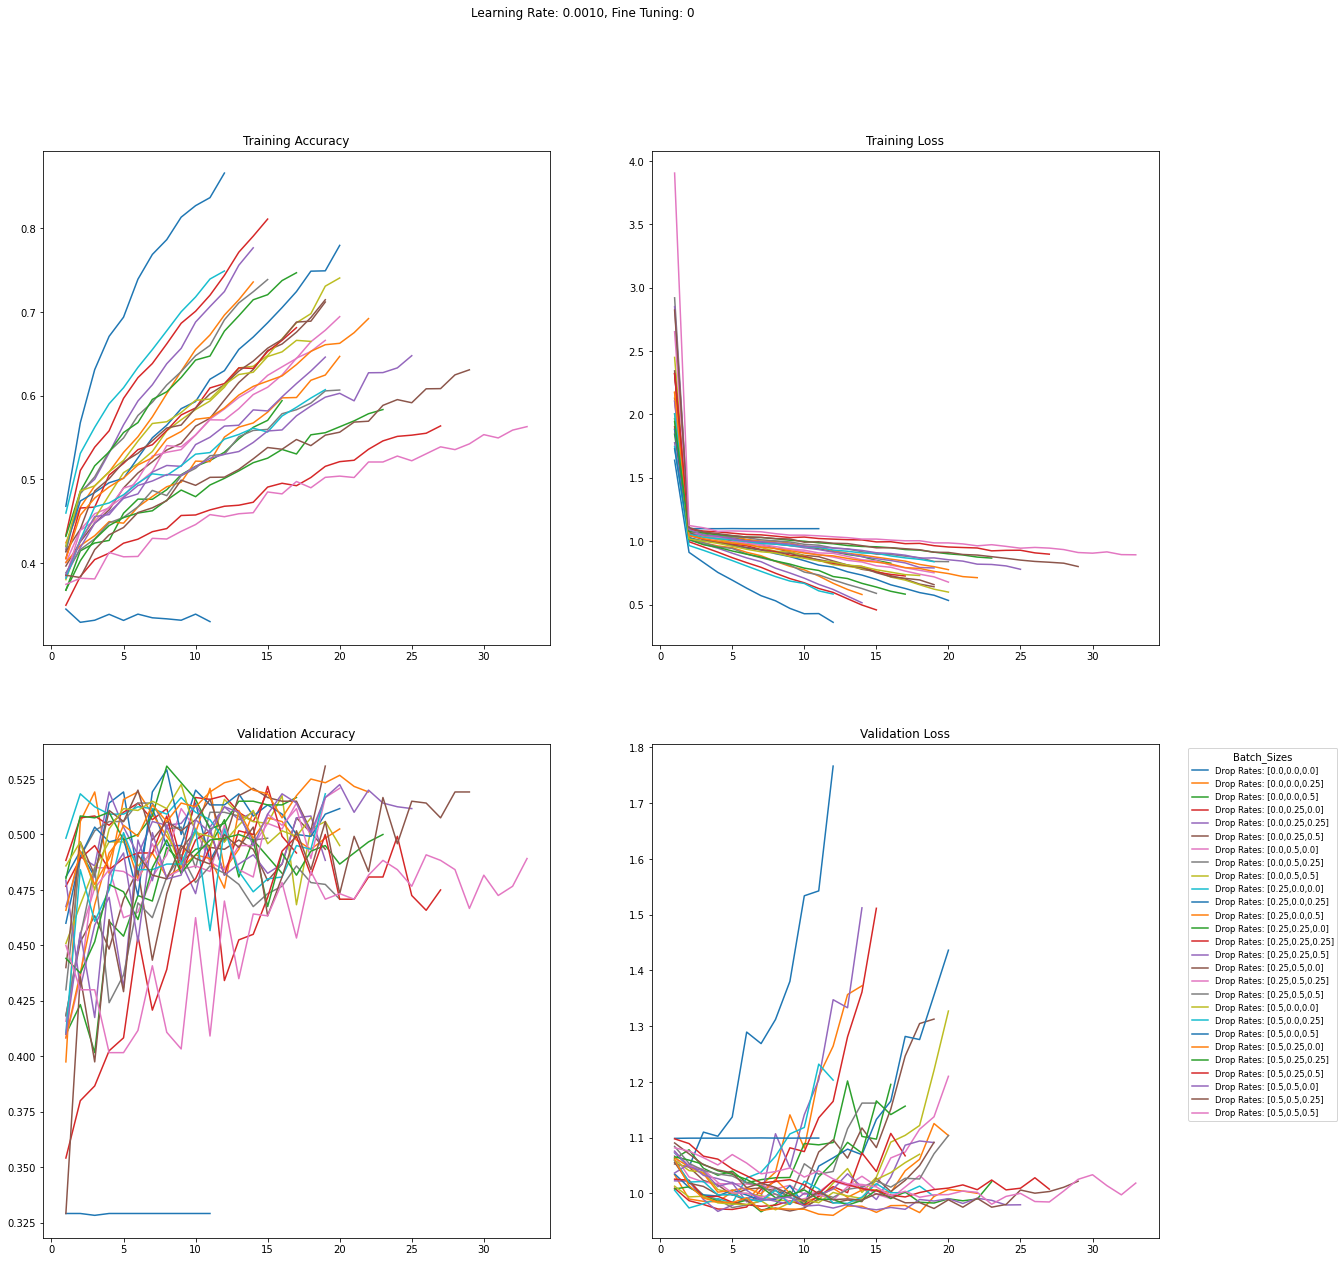

DONE 0 0 0 1
i,j,k,l | 0 0 0 1
i,j,k,l | 0 0 1 1
i,j,k,l | 0 0 2 1
i,j,k,l | 0 1 0 1
i,j,k,l | 0 1 1 1
i,j,k,l | 0 1 2 1
i,j,k,l | 0 2 0 1
i,j,k,l | 0 2 1 1
i,j,k,l | 0 2 2 1
1
i,j,k,l | 1 0 0 1
i,j,k,l | 1 0 1 1
i,j,k,l | 1 0 2 1
i,j,k,l | 1 1 0 1
i,j,k,l | 1 1 1 1
i,j,k,l | 1 1 2 1
i,j,k,l | 1 2 0 1
i,j,k,l | 1 2 1 1
i,j,k,l | 1 2 2 1
2
i,j,k,l | 2 0 0 1
i,j,k,l | 2 0 1 1
i,j,k,l | 2 0 2 1
i,j,k,l | 2 1 0 1
i,j,k,l | 2 1 1 1
i,j,k,l | 2 1 2 1
i,j,k,l | 2 2 0 1
i,j,k,l | 2 2 1 1
i,j,k,l | 2 2 2 1
3


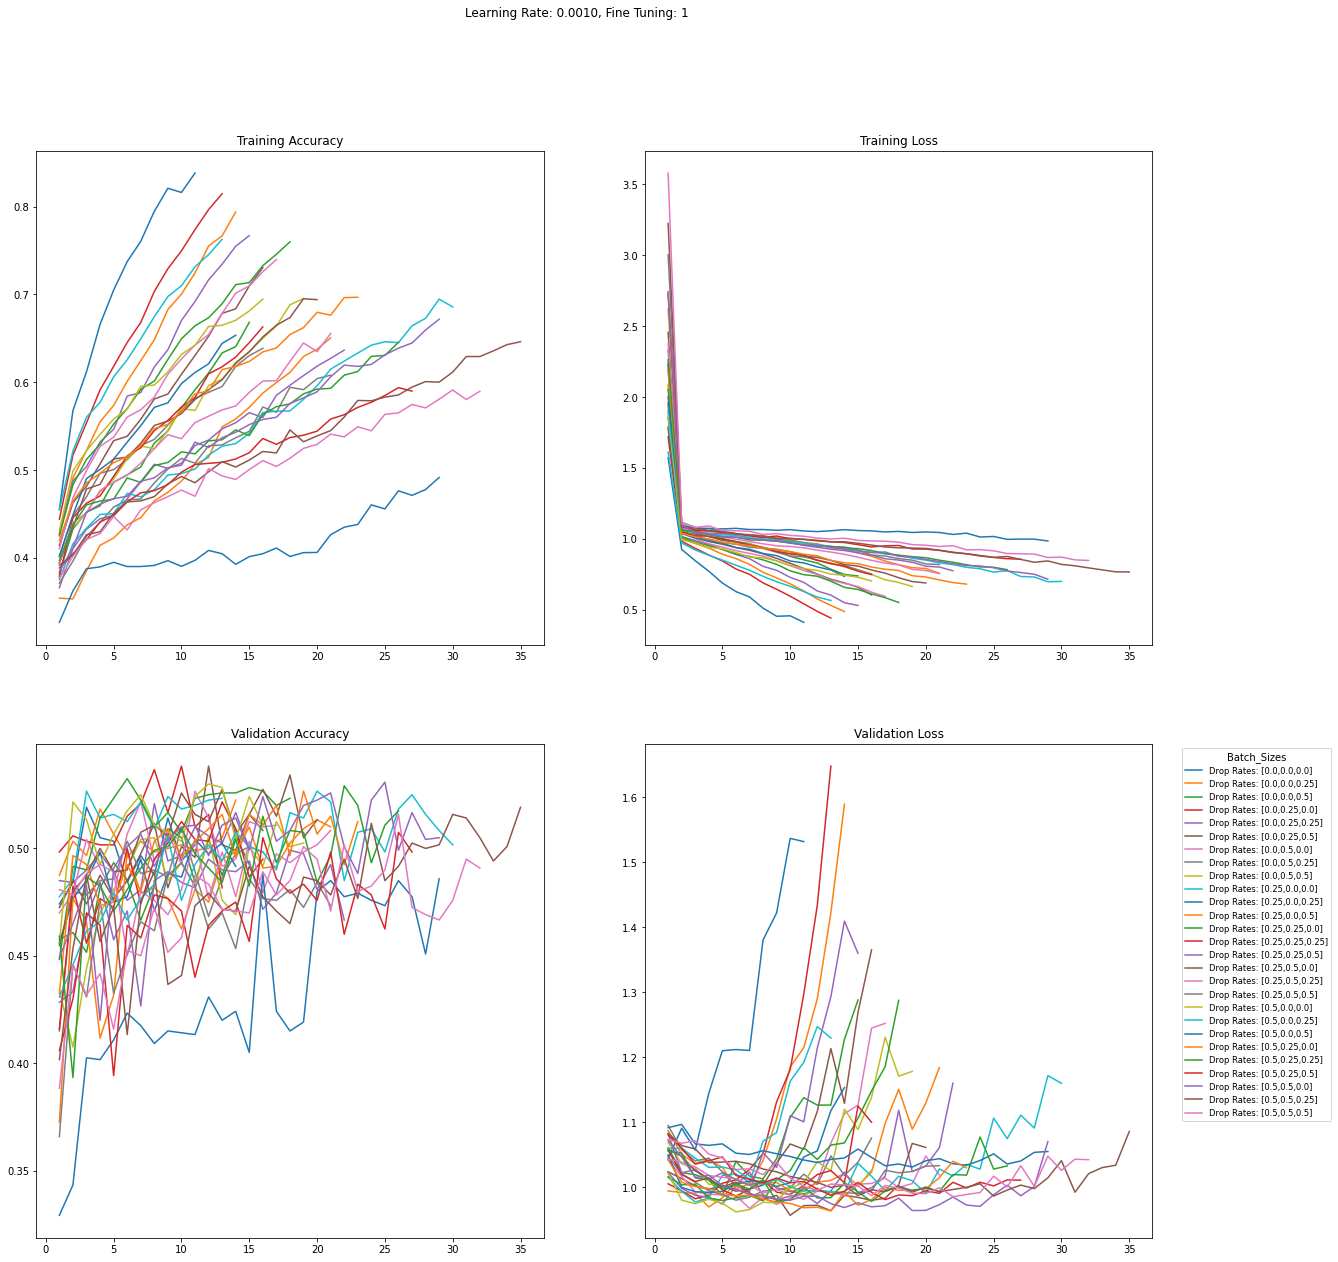

DONE 0 0 0 2
i,j,k,l | 0 0 0 2
i,j,k,l | 0 0 1 2
i,j,k,l | 0 0 2 2
i,j,k,l | 0 1 0 2
i,j,k,l | 0 1 1 2
i,j,k,l | 0 1 2 2
i,j,k,l | 0 2 0 2
i,j,k,l | 0 2 1 2
i,j,k,l | 0 2 2 2
1
i,j,k,l | 1 0 0 2
i,j,k,l | 1 0 1 2
i,j,k,l | 1 0 2 2
i,j,k,l | 1 1 0 2
i,j,k,l | 1 1 1 2
i,j,k,l | 1 1 2 2
i,j,k,l | 1 2 0 2
i,j,k,l | 1 2 1 2
i,j,k,l | 1 2 2 2
2
i,j,k,l | 2 0 0 2
i,j,k,l | 2 0 1 2
i,j,k,l | 2 0 2 2
i,j,k,l | 2 1 0 2
i,j,k,l | 2 1 1 2
i,j,k,l | 2 1 2 2
i,j,k,l | 2 2 0 2
i,j,k,l | 2 2 1 2
i,j,k,l | 2 2 2 2
3


IndexError: ignored

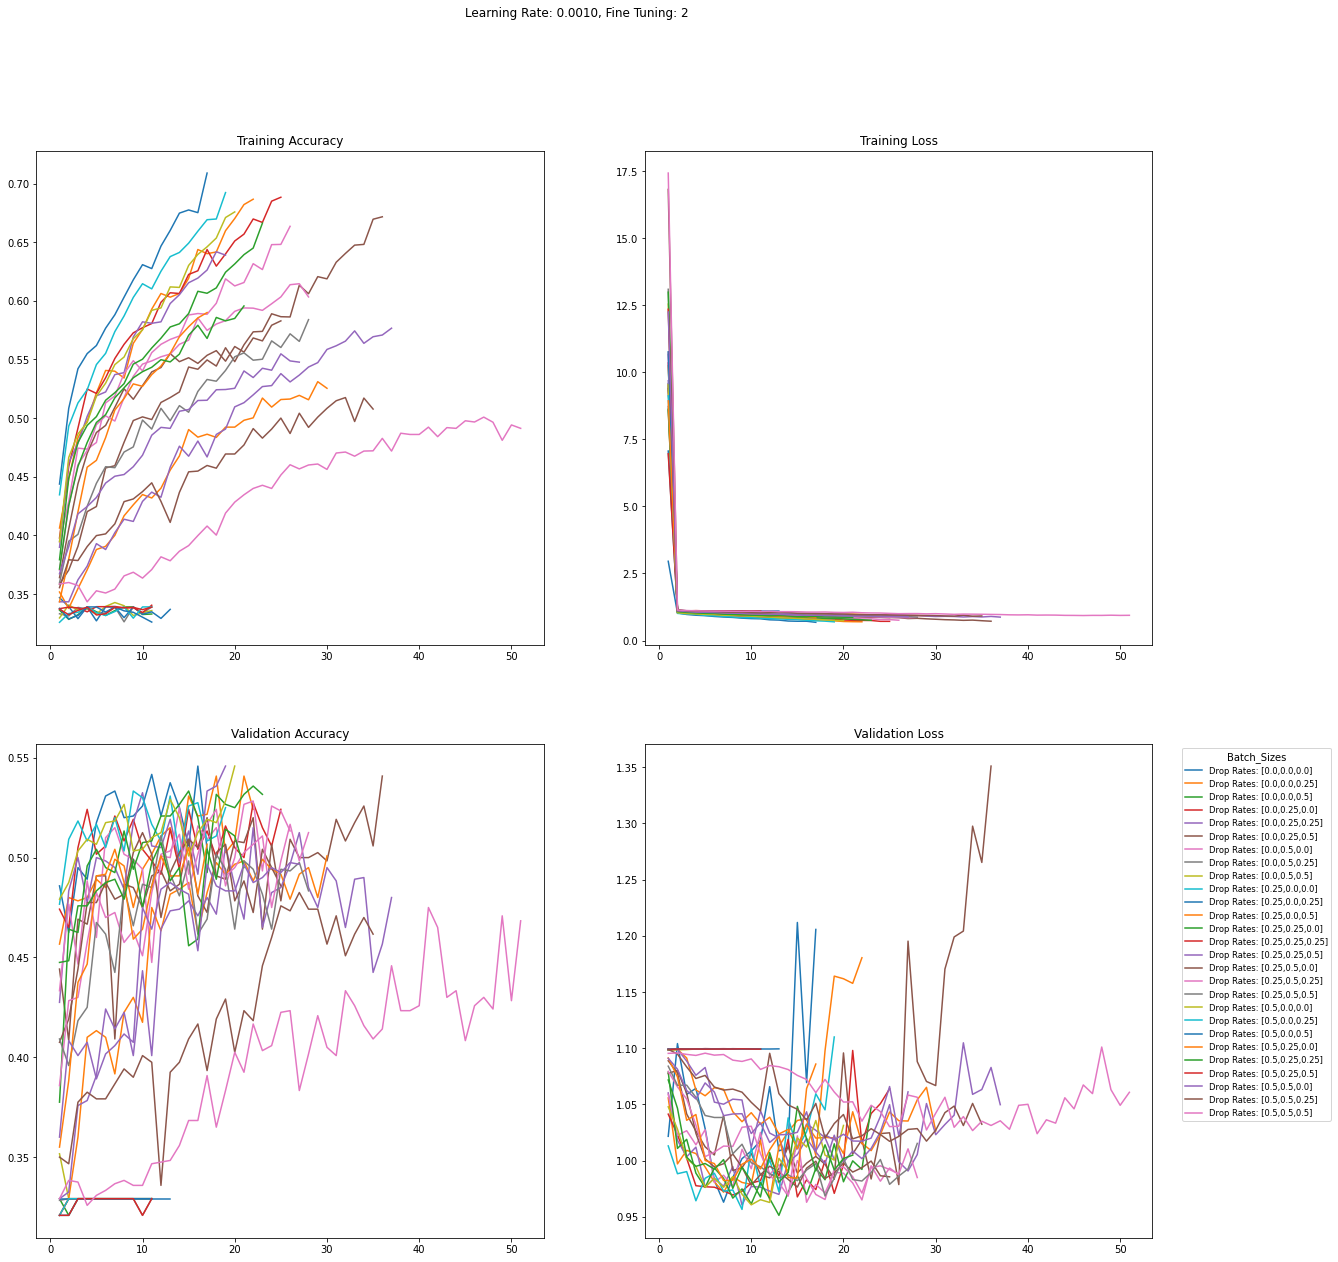

In [ ]:
from matplotlib.font_manager import FontProperties

learning_rate = 0.001
batch_size = 32
i,j,k,l = 0,0,0,0
fontP = FontProperties()
fontP.set_size('small')

for h in history_1:
  print('i,j,k,l', '|', i,j,k,l)
  if i==j==k==0:
    plt.figure(figsize=(20,20))
    plt.suptitle(f'Learning Rate: {learning_rate:.4f}, Fine Tuning: {fine_tune[l]}')
    ax1 = plt.subplot(2,2,1, title='Training Accuracy')
    ax2 = plt.subplot(2,2,2, title='Training Loss')
    ax3 = plt.subplot(2,2,3, title='Validation Accuracy')
    ax4 = plt.subplot(2,2,4, title='Validation Loss')

  tr_acc = h['accuracy']
  tr_loss = h['loss']
  ax1.plot(np.arange(1,len(tr_acc)+1), tr_acc,label=f'Drop Rates: [{dp_rates[i]},{dp_rates[j]},{dp_rates[k]}]')
  ax2.plot(np.arange(1,len(tr_loss)+1), tr_loss,label=f'Drop Rates: [{dp_rates[i]},{dp_rates[j]},{dp_rates[k]}]')

  val_acc = h['val_accuracy']
  val_loss = h['val_loss']
  ax3.plot(np.arange(1,len(val_acc)+1), val_acc,label=f'Drop Rates: [{dp_rates[i]},{dp_rates[j]},{dp_rates[k]}]')
  ax4.plot(np.arange(1,len(val_loss)+1), val_loss,label=f'Drop Rates: [{dp_rates[i]},{dp_rates[j]},{dp_rates[k]}]')

  k += 1
  if k == len(dp_rates):
    k = 0
    j += 1
    if j == len(dp_rates):
      j = 0
      i += 1
      print(i)
      if i == len(dp_rates):  
        i = 0
        l += 1
        plt.legend(title='Batch_Sizes', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
        plt.savefig(os.path.join(save_path, 'Figures/', (f'Learning Rate: {learning_rate:.4f}, Fine Tuning: {fine_tune[l]}.png')))
        plt.show()
        print('DONE', i,j,k,l)

In [ ]:
i,j,k = 0, 0, 1
fontP = FontProperties()
fontP.set_size('small')


for h in history_2:
  if j == 0:
    plt.figure(figsize=(15,15))
    plt.suptitle(f'(Fine Tuning {k} layers) Learning Rate of {learning_rates[i]:.4f}')
    ax1 = plt.subplot(2,2,1, title='Training Accuracy')
    ax2 = plt.subplot(2,2,2, title='Training Loss')
    ax3 = plt.subplot(2,2,3, title='Validation Accuracy')
    ax4 = plt.subplot(2,2,4, title='Validation Loss')

  tr_acc = h['accuracy']
  tr_loss = h['loss']
  ax1.plot(np.arange(1,len(tr_acc)+1), tr_acc,label=f'Batch_size: {batch_size[j]}')
  ax2.plot(np.arange(1,len(tr_loss)+1), tr_loss,label=f'Batch_size: {batch_size[j]}')

  val_acc = h['val_accuracy']
  val_loss = h['val_loss']
  ax3.plot(np.arange(1,len(val_acc)+1), val_acc,label=f'{batch_size[j]}')
  ax4.plot(np.arange(1,len(val_loss)+1), val_loss,label=f'{batch_size[j]}')

  j += 1
  if j == len(batch_size):
    j = 0   
    plt.legend(title='Batch_Sizes', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
    plt.savefig(os.path.join(save_path, 'Figures/', (f'(Fine Tuning {k} layers) Learning Rate of {learning_rates[i]:.4f}.png')))
    plt.show('off')
    i += 1
    if i == len(learning_rates):
      i = 0
      k += 1

In [ ]:
n_epochs = 100
n_classes = 3
input_shape = (32,32,3)
learning_rate = 0.0001
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_func = 'categorical_crossentropy'
dp_rate = 0.6

batch_size = 128

In [ ]:
with strategy.scope():
  vgg16_1 = create_model_1(input_shape, n_classes, optim, loss_func, dp_rate=dp_rate)

### Training the Model
Now that our VGG16 with our custom fully connect top layer is compiled. It is time to fit the model with our nodule images. But first we need to define some callbacks to save the best weights at each epoch and to stop early if there is no change.

In [ ]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5', save_best_only=True, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

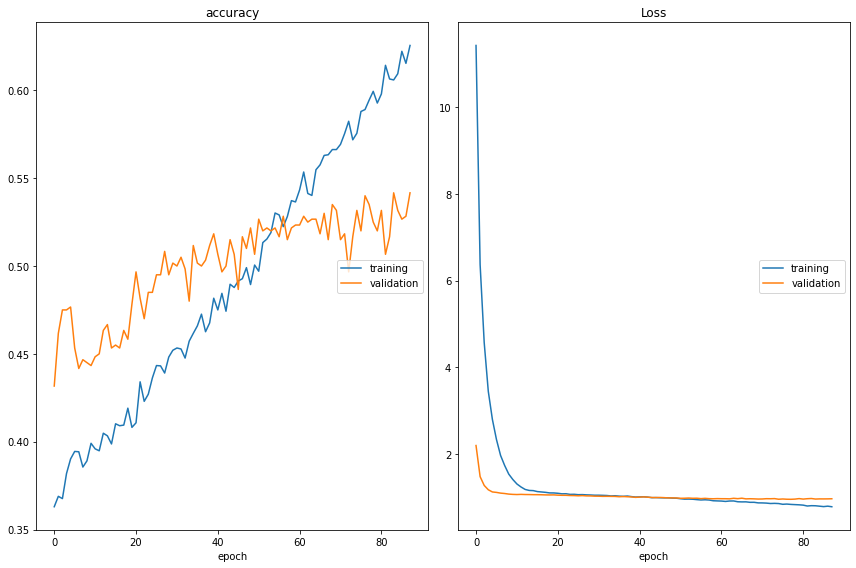

accuracy
	training         	 (min:    0.363, max:    0.626, cur:    0.626)
	validation       	 (min:    0.432, max:    0.542, cur:    0.542)
Loss
	training         	 (min:    0.775, max:   11.430, cur:    0.775)
	validation       	 (min:    0.947, max:    2.189, cur:    0.959)


In [ ]:
%time 
vgg_1_history = vgg16_1.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=n_epochs, verbose=2, callbacks=[tl_checkpoint_1, early_stop, plot_loss_1], validation_split=0.1)

### Predicting with the Test Set

In [ ]:
y_pred_probs_1 = vgg16_1.predict(X_test)
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)
y_true = np.argmax(y_test, axis=1)

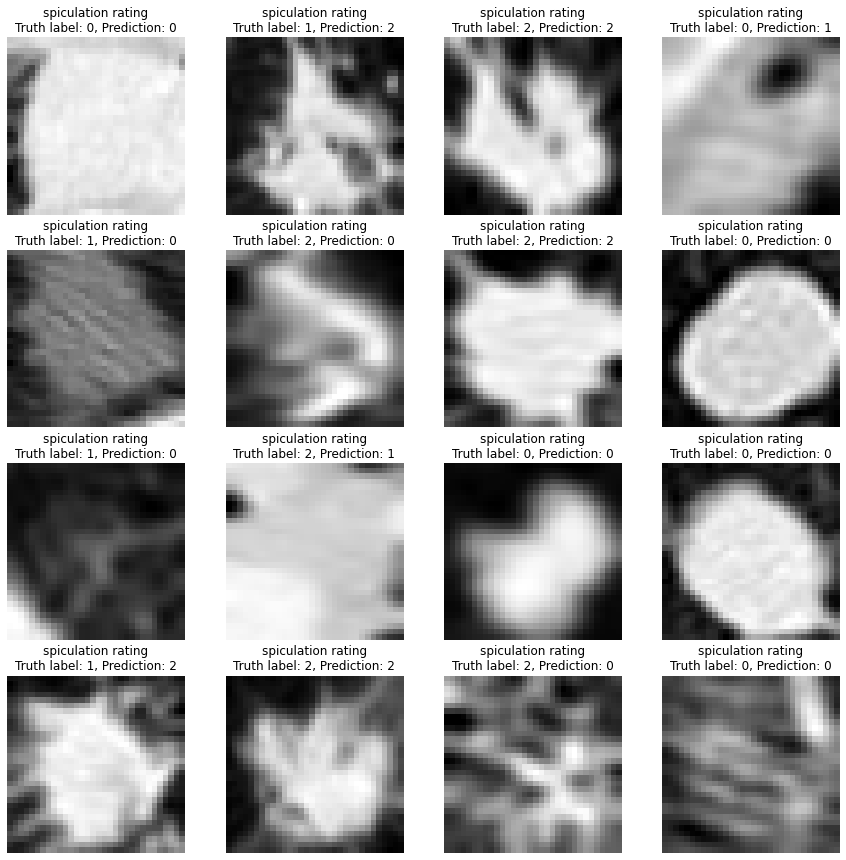

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_test[i].astype("uint8"))
  plt.title(f'spiculation rating\nTruth label: %d, Prediction: %d'%(y_true[i], y_pred_1[i]))
  plt.axis("off")

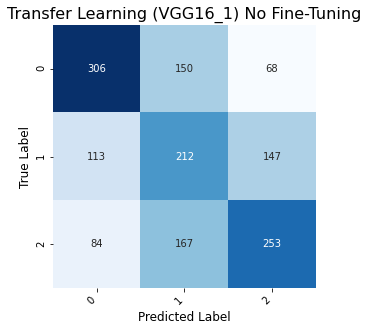

In [ ]:
class_names = ['0','1','2']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_heatmap(y_true, y_pred_1, class_names, ax, title="Transfer Learning (VGG16_1) No Fine-Tuning")    

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
loss, accuracy = vgg16_1.evaluate(X_test, y_test)
print('Test accuracy for Model 1:', accuracy)
print(classification_report(y_true, y_pred_1, digits=3))

47/47 [==============================] - 2s 12ms/step - loss: 0.9816 - accuracy: 0.5140
Test accuracy for Model 1: 0.5139999985694885
              precision    recall  f1-score   support

           0      0.608     0.584     0.596       524
           1      0.401     0.449     0.424       472
           2      0.541     0.502     0.521       504

    accuracy                          0.514      1500
   macro avg      0.517     0.512     0.513      1500
weighted avg      0.520     0.514     0.516      1500



### Fine-Tuning the Model


In [ ]:
optim_2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)
with strategy.scope():
  vgg16_2 = create_model_1(input_shape, n_classes, optim_2, loss_func, fine_tune=1, dp_rate=dp_rate)

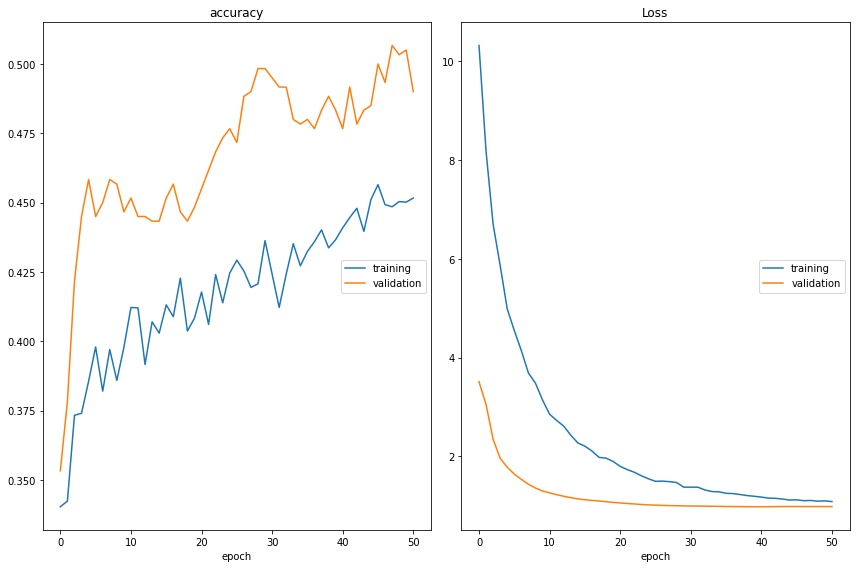

accuracy
	training         	 (min:    0.340, max:    0.456, cur:    0.452)
	validation       	 (min:    0.353, max:    0.507, cur:    0.490)
Loss
	training         	 (min:    1.083, max:   10.324, cur:    1.083)
	validation       	 (min:    0.978, max:    3.510, cur:    0.981)


In [ ]:
plot_loss_2 = PlotLossesCallback()

%time 
vgg_2_history = vgg16_2.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=n_epochs, verbose=2, callbacks=[tl_checkpoint_1, early_stop, plot_loss_2], validation_split=0.1)

In [ ]:
y_pred_probs_2 = vgg16_2.predict(X_test)
y_pred_2 = np.argmax(y_pred_probs_2, axis=1)

In [ ]:
loss, accuracy = vgg16_2.evaluate(X_test, y_test)
print('Test accuracy for Model 2:', accuracy)
print(classification_report(y_true, y_pred_2, digits=3))

47/47 [==============================] - 2s 12ms/step - loss: 1.0011 - accuracy: 0.4940
Test accuracy for Model 2: 0.49399998784065247
              precision    recall  f1-score   support

           0      0.601     0.561     0.580       524
           1      0.387     0.400     0.393       472
           2      0.494     0.512     0.503       504

    accuracy                          0.494      1500
   macro avg      0.494     0.491     0.492      1500
weighted avg      0.498     0.494     0.496      1500



In [ ]:
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_test[i].astype("uint8"))
  plt.title(f'spiculation rating\nTruth label: %d, Prediction: %d'%(y_true[i], y_pred_2[i]))
  plt.axis("off")

### Fine-Tuning the Model 2 Top Layers


In [ ]:
optim_2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)
with strategy.scope():
  vgg16_3 = create_model_1(input_shape, n_classes, optim_2, loss_func, fine_tune=2, dp_rate=dp_rate)

In [ ]:
plot_loss_3 = PlotLossesCallback()

%time 
vgg_3_history = vgg16_3.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=n_epochs, verbose=2, callbacks=[tl_checkpoint_1, early_stop, plot_loss_3], validation_split=0.1)

In [ ]:
y_pred_probs_3 = vgg16_3.predict(X_test)
y_pred_3 = np.argmax(y_pred_probs_3, axis=1)

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(X_test[i].astype("uint8"))
  plt.title(f'spiculation rating\nTruth label: %d, Prediction: %d'%(y_true[i], y_pred_3[i]))
  plt.axis("off")

In [ ]:
loss, accuracy = vgg16_3.evaluate(X_test, y_test)
print('Test accuracy for Model 2:', accuracy)
print(classification_report(y_true, y_pred_3, digits=3))

In [ ]:
class_names = ['0','1','2']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))

plot_heatmap(y_true, y_pred_1, class_names, ax1, title="Transfer Learning (VGG16_1) No Fine-Tuning")    
plot_heatmap(y_true, y_pred_2, class_names, ax2, title="Transfer Learning (VGG16_2) With Fine-Tuning 1 layer")  
plot_heatmap(y_true, y_pred_3, class_names, ax3, title="Transfer Learning (VGG16_2) With Fine-Tuning 2 layers")    


# fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

# Week 2 Data Augmentation


## Preprocessing Part II

In this section, we are going to balance the classes more to improve the accuracy of the model. The previous models had an average acuracy of roughly 78% and we hope that balancing the classes will result in a more acurate model.

Reload the dataset before scaling the image but after binning the classes.

In [ ]:
with open(ds_file_2, 'rb') as f:
  ds = pickle.load(f)

shapes = []
ds2 = []
for d in ds:
  if d[0].shape[0] >= 32 and d[0].shape[1] >= 32:
    shapes.append(d[0].shape)
    ds2.append(d)
del(d)
d = ds2.copy()
del(ds2)
shapes = np.array(shapes)

### Scaling Images


First we want to see how the classes look if we include images bigger than 12x12. Previously we used 4x4 and bigger images. We will also scale the images to 32x32 (redline) instead of 64x64

<function matplotlib.pyplot.show>

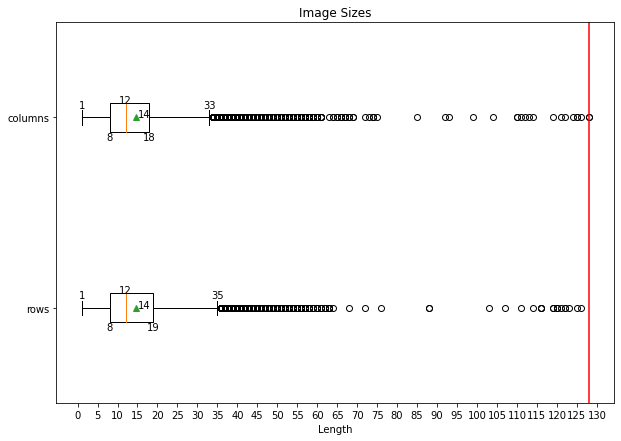

In [ ]:
fig = plt.figure(figsize=(10,7))
bp = plt.boxplot(shapes, showmeans=True, vert=False)

for line in bp['medians']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.text(x, y+.002, '%d' % x,
         horizontalalignment='center') # draw above, centered

for line in bp['whiskers']:
    # get position data for median line
    x, y = line.get_xydata()[1] # top of median line
    # overlay median value
    plt.text(x, y+.05, '%d' % x,
         horizontalalignment='center') # draw above, centered

for line in bp['means']:
    # get position data for median line
    x, y = line.get_xydata()[0] # top of median line
    # overlay median value
    plt.text(x+2, y+.00, '%d' % x,
         horizontalalignment='center') # draw above, centered

for line in bp['boxes']:
    x, y = line.get_xydata()[0] # bottom of left line
    plt.text(x,y-.002, '%d' % x,
         horizontalalignment='center', # centered
         verticalalignment='top')      # below
    x, y = line.get_xydata()[3] # bottom of right line
    plt.text(x,y-.002, '%d' % x,
         horizontalalignment='center', # centered
             verticalalignment='top')      # below

line = plt.axvline(128, 0, color='r')


plt.yticks([1,2], ['rows','columns'])
plt.xticks(np.arange(0,np.max(shapes)+5,step=5))
plt.xlabel('Length')
plt.title('Image Sizes')
plt.savefig(os.path.join(save_path,'image_sizes_before'))
plt.show

Scaling the Images

In [ ]:
temp = []
input_size = (128,128,3)
target_size = input_size[:2]
min_size = (12,12)
for d in ds:
  # Use image with size >= (12,12)
  if d[0].shape >= min_size:
    if d[0].shape < target_size:
      # Up-Scaling
      d[0] = cv2.resize(d[0], dsize=target_size, interpolation=cv2.INTER_CUBIC)
    elif d[0].shape > target_size:
      # Down-Scaling
      d[0] = cv2.resize(d[0], dsize=target_size, interpolation=cv2.INTER_AREA)
    temp.append(d)
del(ds)
ds = temp

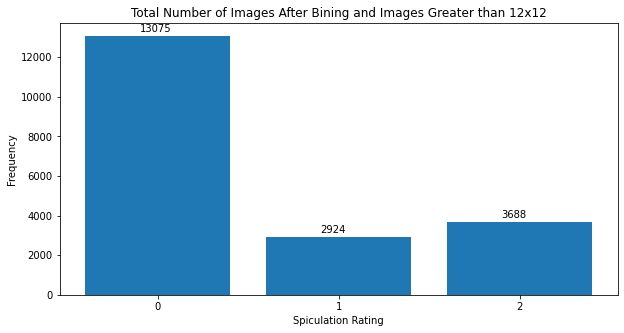

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Total Number of Images After Bining and Images Greater than 12x12')
labels, counts = np.unique([d[1] for d in ds], return_counts='True')
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Frequency')
plt.xlabel('Spiculation Rating')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + 200, yval)
plt.savefig(os.path.join(save_path,'bar_bin'))
plt.show()

As we can see this significantly reduced our dataset. Class 0 is smaller but so is Class 1. We still need to balance the class size though.

### Grayscale -> RGB
Unfortunately VGG16 only takes RGB images. Since our images are grayscale, I'm just going to clone the image matrix to each color channel.

In [ ]:
for d in ds:
  d[0] = np.dstack([d[0]]*3)

### Randomly Sample from Classes

First we will split the elements into three list coresponding to thier class.

In [ ]:
class_0, class_1, class_2 = [],[],[]
for d in ds:
  if d[1] == 0:
    class_0.append(d)
  elif d[1] == 1:
    class_1.append(d)
  elif d[1] == 2:
    class_2.append(d)

bin_size = min(len(class_0), len(class_1), len(class_2))
bin_size

2924

In order to balance the classes we decided on randomly sampling from each class until we have an equal number of samples from each class. To try this method out. We will be sampling total of 2900 samples from each class.

In [ ]:
# ds2 = []
# Current number of samples randomly sampled from each class.
num_0, num_1, num_2 = 0,0,0
del(ds)
ds = []
# Randomly sample from each class with out replacement until we have balanced classes.
# Begin with randomly selecting from class 0
used = set()
while num_0 < bin_size:
  idx = np.random.randint(low=0, high=len(class_0))
  if idx not in used:
    rand_sample = class_0[idx].copy()
    ds.append(rand_sample)
    used.add(idx)
    num_0 += 1


# Reset and run for class 1
used = set()
while num_1 < bin_size:
  idx = np.random.randint(low=0, high=len(class_1))
  if idx not in used:
    rand_sample = class_1[idx].copy()
    ds.append(rand_sample)
    used.add(idx)
    num_1 += 1

# Reset and run for class 2
used = set()
while num_2 < bin_size:
  idx = np.random.randint(low=0, high=len(class_2))
  if idx not in used:
    rand_sample = class_2[idx].copy()
    ds.append(rand_sample)
    used.add(idx)
    num_2 += 1

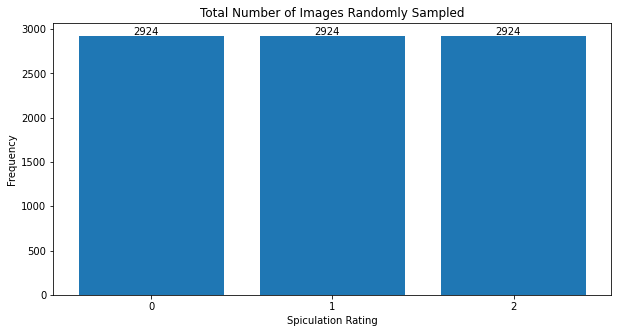

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.title('Total Number of Images Randomly Sampled')
labels, counts = np.unique([d[1] for d in ds], return_counts='True')
bars = plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.ylabel('Frequency')
plt.xlabel('Spiculation Rating')
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+0.3, yval + 10, yval)
plt.savefig(os.path.join(save_path,'bar_bin'))
plt.show()

Much better results. We have a balanced dataset but we have significantly reduced the number of images though. Now we will see if this tradeoff is worth it. But first a couple more of preprocessing before we begin trading our model.

### Split Training and Test Sets
Now that we have the dataset ready. Its time to split it into training and test sets, as well as randomizing and converting to tensors.

In [ ]:
X = []
y = []
for d in ds:
  X.append(d[0])
  y.append(d[1])
X = np.array(X)
y = np.array(y)
y

array([0, 0, 0, ..., 2, 2, 2])

Lastly, we will also use One-Hot Encoding on the labels.

In [ ]:
# y = LabelBinarizer().fit_transform(y)
y = tf.keras.utils.to_categorical(y, num_classes=3)
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [ ]:
print('Training Set Size:',len(X_train), '\nTest Set Size:', len(X_test))

Training Set Size: 7017 
Test Set Size: 1755


In [ ]:
ImgGen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, shear_range=10, horizontal_flip=True, brightness_range=[0.5,1.5], vertical_flip=True, width_shift_range=.1, height_shift_range=.1, validation_split=.2, dtype=tf.uint8)
train_generator = ImgGen.flow(X_train, y_train, batch_size=64, subset='training', seed=1)
val_generator = ImgGen.flow(X_train, y_train, batch_size=64, subset='validation', seed=1)

## Best Model No Regularization and Fine Tuning

### Training

In [ ]:
learning_rate = 0.0001
batch_size = 64

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
n_epochs = 100
n_classes = 3
loss_func = 'categorical_crossentropy'
fine_tune = 0
# input_shape = (64,64,3)

optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)
with strategy.scope():
  best_model_1 = create_model_1(input_size, n_classes, optim, loss_func, fine_tune)

80142336/80134624 [==============================] - 2s 0us/step


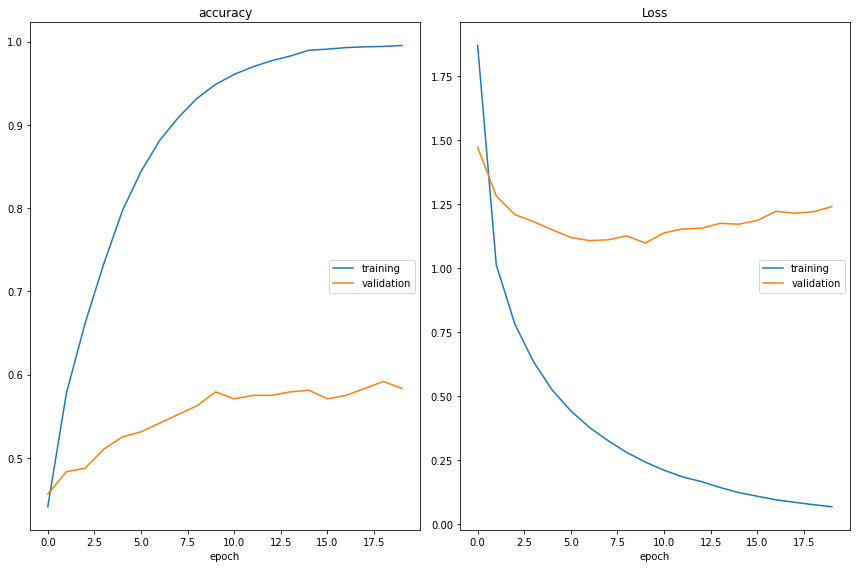

accuracy
	training         	 (min:    0.441, max:    0.995, cur:    0.995)
	validation       	 (min:    0.456, max:    0.592, cur:    0.583)
Loss
	training         	 (min:    0.069, max:    1.869, cur:    0.069)
	validation       	 (min:    1.098, max:    1.472, cur:    1.240)


In [ ]:
plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5', save_best_only=True, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

best_model_1_history = best_model_1.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=n_epochs, verbose=2, callbacks=[tl_checkpoint_1, early_stop, plot_loss_1], validation_split=0.1)

### Testing

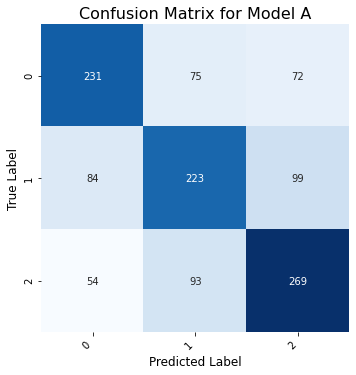

In [ ]:
y_pred_probs_1 = best_model_1.predict(X_test)
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)
y_true = np.argmax(y_test, axis=1)

class_names = ['0','1','2']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_heatmap(y_true, y_pred_1, class_names, ax, title="Confusion Matrix for Model A")    

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_1, digits=3))

              precision    recall  f1-score   support

           0      0.626     0.611     0.618       378
           1      0.570     0.549     0.560       406
           2      0.611     0.647     0.629       416

    accuracy                          0.603      1200
   macro avg      0.603     0.602     0.602      1200
weighted avg      0.602     0.603     0.602      1200



## Best Model With Regularization and Fine Tuning

### Training

In [ ]:
learning_rate = 0.0001
batch_size = 64

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')
n_epochs = 10000
n_classes = 3
# input_shape = (64,64,3)
loss_func = 'categorical_crossentropy'
dp_rates = [.2, .25, .2]
fine_tune = 1

optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)
with strategy.scope():
  best_model_2 = create_model_2(input_size, n_classes, dp_rates, optim, loss_func, fine_tune=fine_tune)

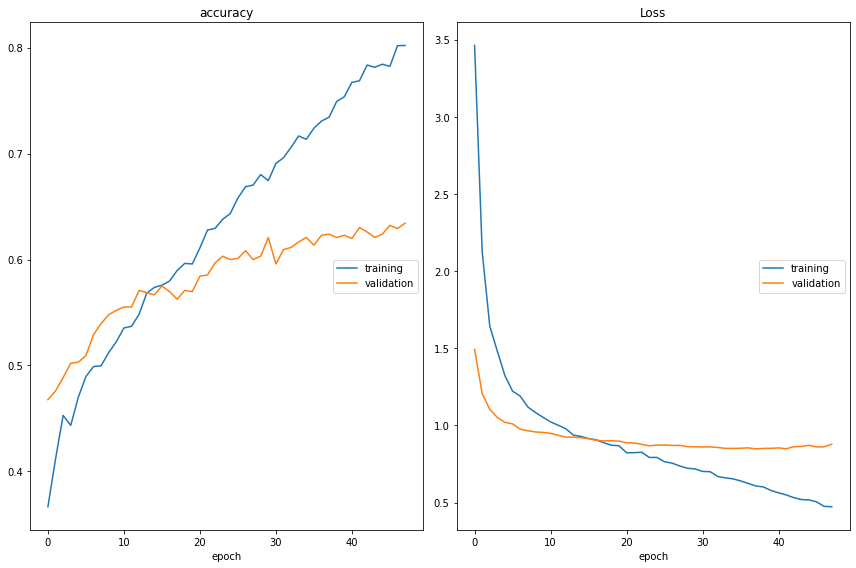

accuracy
	training         	 (min:    0.367, max:    0.802, cur:    0.802)
	validation       	 (min:    0.468, max:    0.634, cur:    0.634)
Loss
	training         	 (min:    0.474, max:    3.462, cur:    0.474)
	validation       	 (min:    0.848, max:    1.493, cur:    0.879)


In [ ]:
plot_loss_2 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5', save_best_only=True, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

best_model_2_history = best_model_2.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=n_epochs, verbose=2, callbacks=[tl_checkpoint_2, early_stop, plot_loss_2], validation_split=0.2)

### Testing

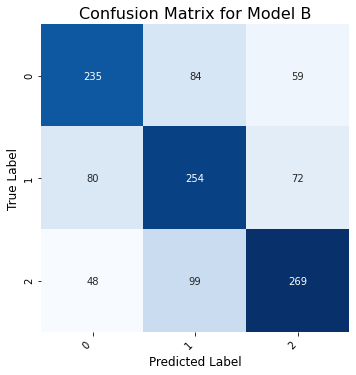

In [ ]:
y_pred_probs_2 = best_model_2.predict(X_test)
y_pred_2 = np.argmax(y_pred_probs_2, axis=1)
y_true = np.argmax(y_test, axis=1)

class_names = ['0','1','2']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

plot_heatmap(y_true, y_pred_2, class_names, ax, title="Confusion Matrix for Model B")    

fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

In [ ]:
print(classification_report(y_true, y_pred_2, digits=4))

              precision    recall  f1-score   support

           0     0.6474    0.6217    0.6343       378
           1     0.5812    0.6256    0.6026       406
           2     0.6725    0.6466    0.6593       416

    accuracy                         0.6317      1200
   macro avg     0.6337    0.6313    0.6321      1200
weighted avg     0.6337    0.6317    0.6322      1200



## Save the best model between the two

In [ ]:
best_model_2.save(save_path+'best_model.h5')

# Grad-CAM

In [ ]:
model = best_model_2
model.summary()

Model: "model_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0 

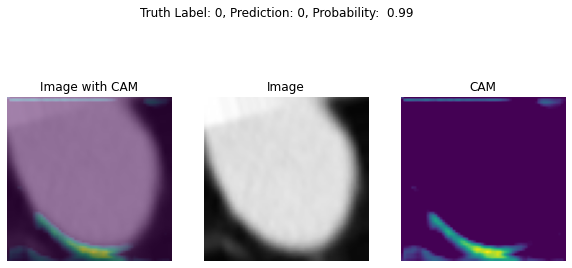

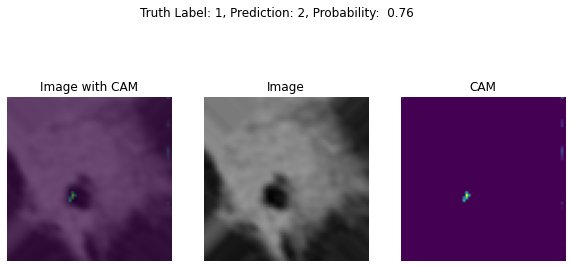

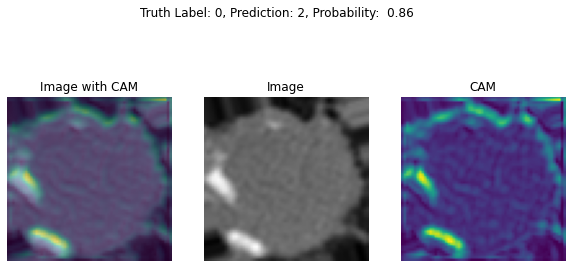

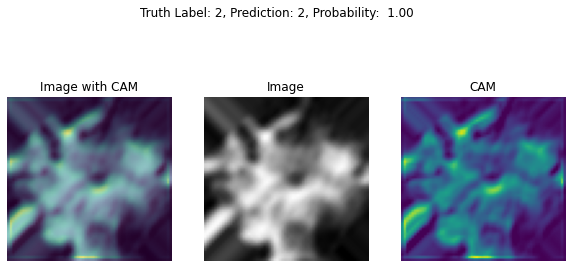

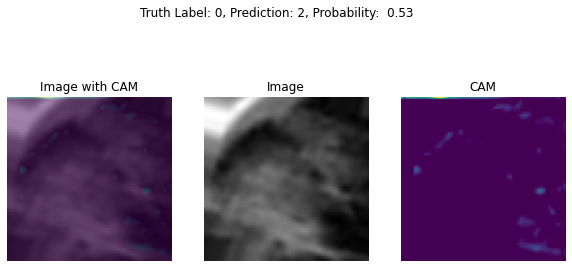

In [ ]:
last_conv_layer = 'block1_conv2'
match = []
indicies = []
for idx,(img,label) in enumerate(zip(X_test,y_test)):
  i = np.random.randint(0,10)
  j = np.random.randint(0,10)
  show = False
  if i == j:
    match.append((img, label))
    indicies.append(idx)
    show = True
  gradcam(img, model, last_conv_layer, np.argmax(label), show=show)
  # guided_gradcam(img, model, last_conv_layer, np.argmax(label), show=show)
  if len(match) == 5:
    break

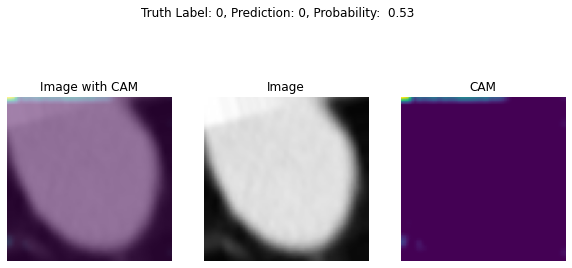

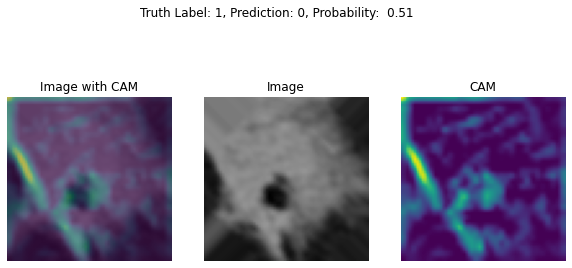

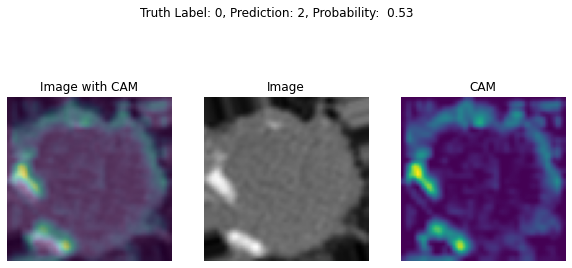

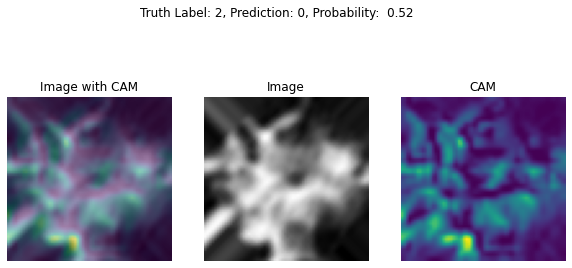

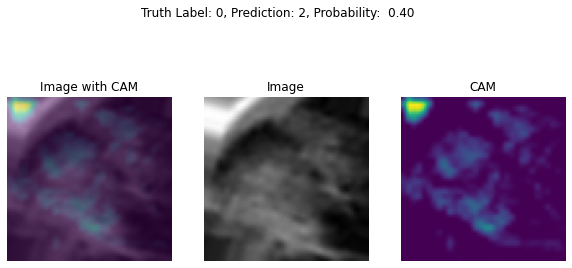

In [ ]:
last_conv_layer = 'block2_conv2'
for img,label in match:
  gradcam(img, model, last_conv_layer, np.argmax(label), show=True)
  # guided_gradcam(img, model, last_conv_layer, np.argmax(label), show=True)

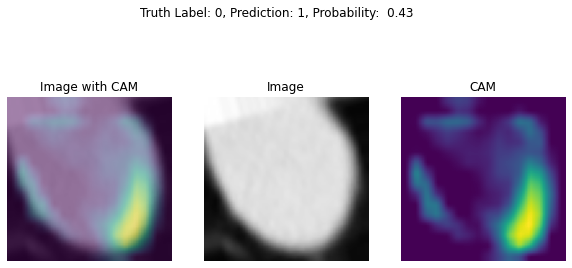

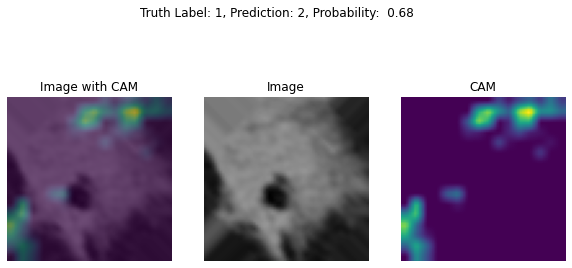

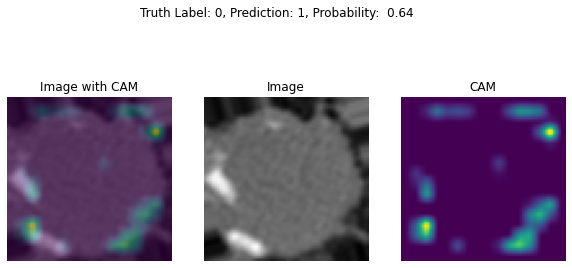

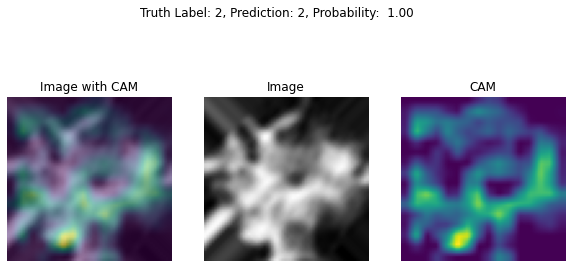

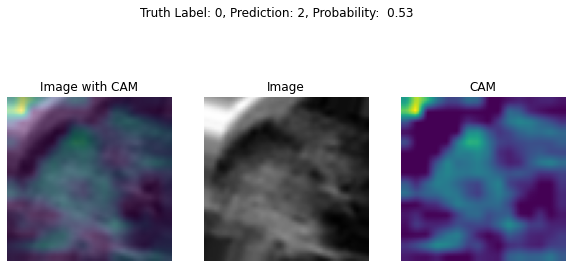

In [ ]:
last_conv_layer = 'block3_conv3'
for img,label in match:
  gradcam(img, model, last_conv_layer, np.argmax(label), show=True)
  # guided_gradcam(img, model, last_conv_layer, np.argmax(label), show=True)

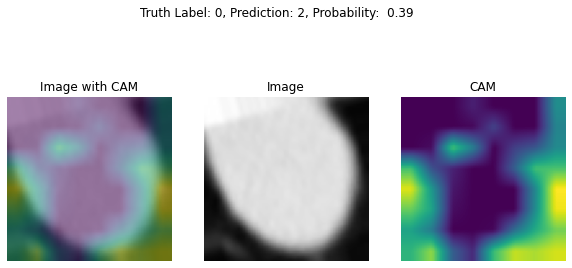

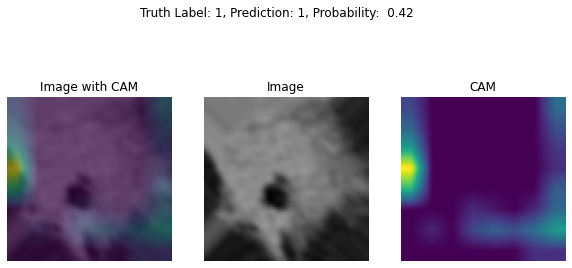

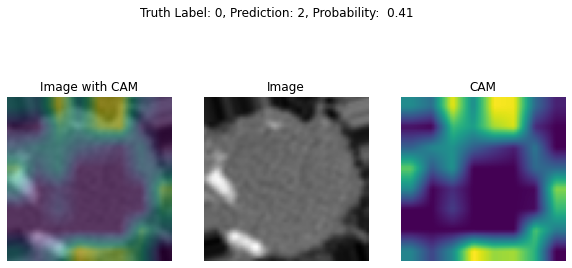

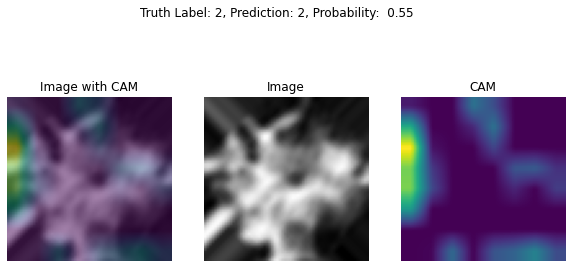

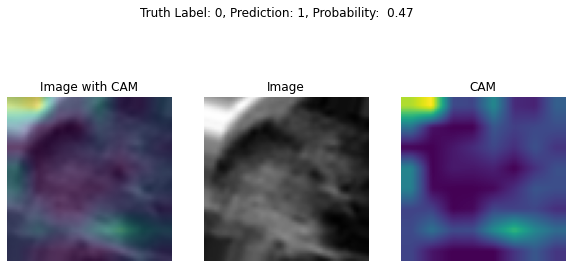

In [ ]:
last_conv_layer = 'block4_conv3'
for img,label in match:
  gradcam(img, model, last_conv_layer, np.argmax(label), show=True)
  # guided_gradcam(img, model, last_conv_layer, np.argmax(label), show=True)

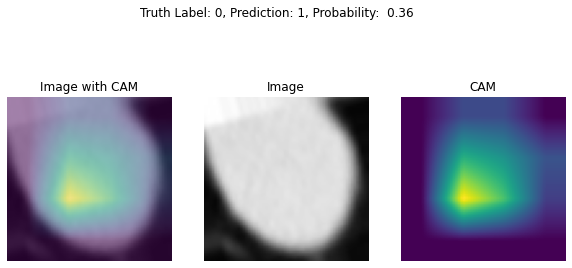

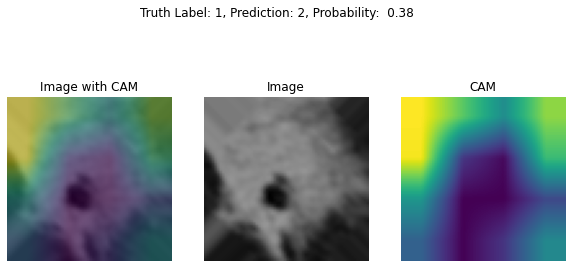

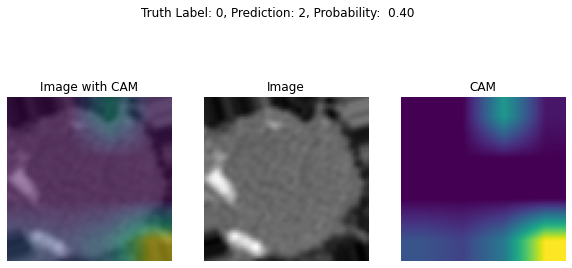

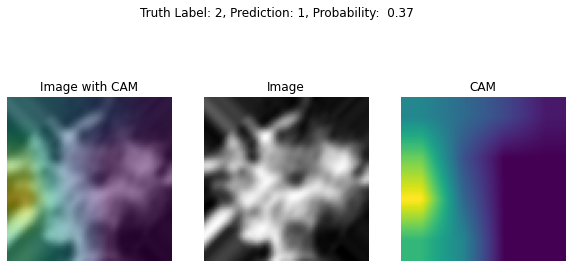

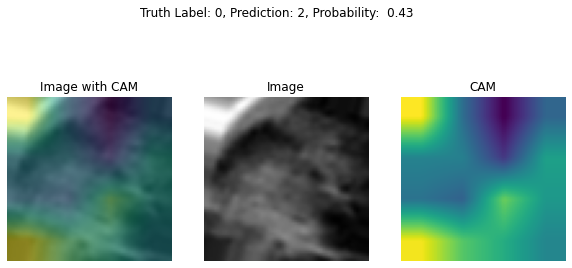

In [ ]:
last_conv_layer = 'block5_conv3'
for img,label in match:
  gradcam(img, model, last_conv_layer, np.argmax(label), show=True)
  # guided_gradcam(img, model, last_conv_layer, np.argmax(label), show=True)

In [ ]:
for idx in indicies:
  print(y_true[idx],y_pred_2[idx])

0 0
1 1
0 0
2 2
0 1
